In [1]:
%pip install --upgrade -e ../../.
%pip install datasets

Obtaining file:///root/peft
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for peft (pyproject.toml) ... done
  Created wheel for peft: filename=peft-0.6.0.dev1-0.editable-py3-none-any.whl size=12911 sha256=11fe54ccaf1efd453f93be9b75126be7360a68cf0231066801be47b2da0b6c0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-fc1muukb/wheels/50/61/2f/c8d90f80efe6c7f0d9c25eb3c6fb64f6c5d2848dd643973058
Successfully built peft
  Attempting uninstall: peft
    Found existing installation: peft 0.6.0.dev1
    Uninstalling peft-0.6.0.dev1:
      Successfully uninstalled peft-0.6.0.dev1

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3

In [1]:
from transformers import AutoModelForCausalLM

# from peft import get_peft_config, get_peft_model, PrefixTuningConfig, TaskType, PeftType
from peft import get_peft_config, get_peft_model, CoregPromptTuningConfig, TaskType, PeftType, LoraConfig,PromptEncoderConfig, PromptTuningConfig, PromptTuningInit

import torch
from datasets import load_dataset
import os
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset

device = "cuda"
model_name_or_path = "bigscience/bloomz-560m"
tokenizer_name_or_path = "bigscience/bloomz-560m"


dataset_name = "twitter_complaints"
# checkpoint_name = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace(
#     "/", "_"
# )
text_column = "Tweet text"
label_column = "text_label"
max_length = 64
lr = 1e-2
num_epochs = 50
batch_size = 8

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

dataset = load_dataset("ought/raft", dataset_name)

classes = [k.replace("_", " ") for k in dataset["train"].features["Label"].names]
print(classes)
dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["Label"]]},
    batched=True,
    num_proc=1,
)
print(dataset)
dataset["train"][0]

['Unlabeled', 'complaint', 'no complaint']
DatasetDict({
    train: Dataset({
        features: ['Tweet text', 'ID', 'Label', 'text_label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['Tweet text', 'ID', 'Label', 'text_label'],
        num_rows: 3399
    })
})


{'Tweet text': '@HMRCcustomers No this is my first job',
 'ID': 0,
 'Label': 2,
 'text_label': 'no complaint'}

In [3]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
target_max_length = max([len(tokenizer(class_label)["input_ids"]) for class_label in classes])
print(target_max_length)


def preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x} Label : " for x in examples[text_column]]
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets, add_special_tokens=False)  # don't add bos token because we concatenate with inputs
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.eos_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["train"]


train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

3


Running tokenizer on dataset: 100%|██████████| 3399/3399 [00:00<00:00, 6404.27 examples/s]


In [4]:
def test_preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x} Label : " for x in examples[text_column]]
    model_inputs = tokenizer(inputs)
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
    return model_inputs


test_dataset = dataset["test"].map(
    test_preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

test_dataloader = DataLoader(test_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)


Running tokenizer on dataset: 100%|██████████| 3399/3399 [00:00<00:00, 7743.99 examples/s] 


# Set approximately equal param %

In [32]:
orig_model = AutoModelForCausalLM.from_pretrained(model_name_or_path)

In [34]:

print("Coreg tuning")
coreg_config = CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
                                      num_views=4, 
                                      num_virtual_tokens=85,
                                      token_dim=1024,
                                      attention_dim=1024)

model = get_peft_model(orig_model, coreg_config)
model.print_trainable_parameters()

print("LORA tuning")
lora_config = LoraConfig(
    r=85,
    lora_alpha=16,
    target_modules=["query_key_value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
model = get_peft_model(orig_model, lora_config)
model.print_trainable_parameters()

print("P Tuning (LSTM)")
p_tuning_config_l = PromptEncoderConfig(
    peft_type="P_TUNING",
    task_type=TaskType.CAUSAL_LM,
    num_virtual_tokens=50,
    token_dim=1024,
    num_transformer_submodules=1,
    num_attention_heads=4,
    num_layers=6,
    encoder_reparameterization_type="LSTM",
    encoder_hidden_size=362,
)
model = get_peft_model(orig_model, p_tuning_config_l)
model.print_trainable_parameters()

print("P Tuning (MLP)")
p_tuning_config = PromptEncoderConfig(
    peft_type="P_TUNING",
    task_type=TaskType.CAUSAL_LM,
    num_virtual_tokens=50,
    token_dim=1024,
    num_transformer_submodules=1,
    num_attention_heads=4,
    num_layers=6,
    encoder_reparameterization_type="MLP",
    encoder_hidden_size=2053,
)
    
model = get_peft_model(orig_model, p_tuning_config)
model.print_trainable_parameters()



Coreg tuning
trainable params: 8,483,840 || all params: 576,054,272 || trainable%: 1.4727501230995124
LORA tuning
trainable params: 8,355,840 || all params: 567,570,432 || trainable%: 1.472211998527788
P Tuning (LSTM)
trainable params: 8,488,996 || all params: 576,059,428 || trainable%: 1.473631987844143
P Tuning (MLP)
trainable params: 8,475,683 || all params: 576,046,115 || trainable%: 1.4713549452546868


In [35]:
del model
del orig_model

In [36]:
def train(config):
    
    orig_model = AutoModelForCausalLM.from_pretrained(model_name_or_path)

    model = get_peft_model(orig_model, config)
    
    model.print_trainable_parameters()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=(len(train_dataloader) * num_epochs),
    )

    ### training and evaluation
    model = model.to(device)

    eval_history=[]
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for step, batch in enumerate(tqdm(train_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            #         print(batch)
            #         print(batch["input_ids"].shape)
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.detach().float()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        model.eval()
        eval_loss = 0
        eval_preds = []
        for step, batch in enumerate(tqdm(eval_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            loss = outputs.loss
            eval_loss += loss.detach().float()
            eval_preds.extend(
                tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
            )

        eval_epoch_loss = eval_loss / len(eval_dataloader)
        eval_ppl = torch.exp(eval_epoch_loss)
        train_epoch_loss = total_loss / len(train_dataloader)
        train_ppl = torch.exp(train_epoch_loss)
        print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")
        eval_history.append(float(eval_epoch_loss))
        
    del model
    del orig_model
    del optimizer
    del lr_scheduler
    
    return eval_history

In [37]:
%%time
coreg_history = train(coreg_config)
%store coreg_history

trainable params: 8,483,840 || all params: 567,698,432 || trainable%: 1.4944272384391577


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=0: train_ppl=tensor(138.7386, device='cuda:0') train_epoch_loss=tensor(4.9326, device='cuda:0') eval_ppl=tensor(22.0765, device='cuda:0') eval_epoch_loss=tensor(3.0945, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=1: train_ppl=tensor(3.4500, device='cuda:0') train_epoch_loss=tensor(1.2384, device='cuda:0') eval_ppl=tensor(1.5311, device='cuda:0') eval_epoch_loss=tensor(0.4260, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=2: train_ppl=tensor(3.1297, device='cuda:0') train_epoch_loss=tensor(1.1409, device='cuda:0') eval_ppl=tensor(1.5595, device='cuda:0') eval_epoch_loss=tensor(0.4444, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=3: train_ppl=tensor(1.5271, device='cuda:0') train_epoch_loss=tensor(0.4234, device='cuda:0') eval_ppl=tensor(1.3063, device='cuda:0') eval_epoch_loss=tensor(0.2672, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=4: train_ppl=tensor(1.3024, device='cuda:0') train_epoch_loss=tensor(0.2642, device='cuda:0') eval_ppl=tensor(1.2403, device='cuda:0') eval_epoch_loss=tensor(0.2153, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=5: train_ppl=tensor(1.2405, device='cuda:0') train_epoch_loss=tensor(0.2155, device='cuda:0') eval_ppl=tensor(1.3547, device='cuda:0') eval_epoch_loss=tensor(0.3036, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=6: train_ppl=tensor(1.3130, device='cuda:0') train_epoch_loss=tensor(0.2723, device='cuda:0') eval_ppl=tensor(1.2726, device='cuda:0') eval_epoch_loss=tensor(0.2411, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=7: train_ppl=tensor(1.3468, device='cuda:0') train_epoch_loss=tensor(0.2977, device='cuda:0') eval_ppl=tensor(1.3325, device='cuda:0') eval_epoch_loss=tensor(0.2871, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=8: train_ppl=tensor(1.2638, device='cuda:0') train_epoch_loss=tensor(0.2341, device='cuda:0') eval_ppl=tensor(1.2176, device='cuda:0') eval_epoch_loss=tensor(0.1969, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=9: train_ppl=tensor(1.2667, device='cuda:0') train_epoch_loss=tensor(0.2364, device='cuda:0') eval_ppl=tensor(1.2087, device='cuda:0') eval_epoch_loss=tensor(0.1896, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


epoch=10: train_ppl=tensor(1.2950, device='cuda:0') train_epoch_loss=tensor(0.2585, device='cuda:0') eval_ppl=tensor(1.2678, device='cuda:0') eval_epoch_loss=tensor(0.2373, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


epoch=11: train_ppl=tensor(1.2448, device='cuda:0') train_epoch_loss=tensor(0.2189, device='cuda:0') eval_ppl=tensor(1.2037, device='cuda:0') eval_epoch_loss=tensor(0.1854, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=12: train_ppl=tensor(1.2325, device='cuda:0') train_epoch_loss=tensor(0.2090, device='cuda:0') eval_ppl=tensor(1.1960, device='cuda:0') eval_epoch_loss=tensor(0.1790, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


epoch=13: train_ppl=tensor(1.2142, device='cuda:0') train_epoch_loss=tensor(0.1941, device='cuda:0') eval_ppl=tensor(1.2017, device='cuda:0') eval_epoch_loss=tensor(0.1837, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.56it/s]


epoch=14: train_ppl=tensor(1.1938, device='cuda:0') train_epoch_loss=tensor(0.1772, device='cuda:0') eval_ppl=tensor(1.1852, device='cuda:0') eval_epoch_loss=tensor(0.1699, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=15: train_ppl=tensor(1.2041, device='cuda:0') train_epoch_loss=tensor(0.1857, device='cuda:0') eval_ppl=tensor(1.1730, device='cuda:0') eval_epoch_loss=tensor(0.1596, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=16: train_ppl=tensor(1.2404, device='cuda:0') train_epoch_loss=tensor(0.2154, device='cuda:0') eval_ppl=tensor(1.2293, device='cuda:0') eval_epoch_loss=tensor(0.2064, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=17: train_ppl=tensor(1.2453, device='cuda:0') train_epoch_loss=tensor(0.2193, device='cuda:0') eval_ppl=tensor(1.2156, device='cuda:0') eval_epoch_loss=tensor(0.1953, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=18: train_ppl=tensor(1.3146, device='cuda:0') train_epoch_loss=tensor(0.2735, device='cuda:0') eval_ppl=tensor(1.2678, device='cuda:0') eval_epoch_loss=tensor(0.2373, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=19: train_ppl=tensor(1.5821, device='cuda:0') train_epoch_loss=tensor(0.4587, device='cuda:0') eval_ppl=tensor(1.2798, device='cuda:0') eval_epoch_loss=tensor(0.2467, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=20: train_ppl=tensor(1.2799, device='cuda:0') train_epoch_loss=tensor(0.2468, device='cuda:0') eval_ppl=tensor(1.3128, device='cuda:0') eval_epoch_loss=tensor(0.2722, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=21: train_ppl=tensor(1.2589, device='cuda:0') train_epoch_loss=tensor(0.2303, device='cuda:0') eval_ppl=tensor(1.1935, device='cuda:0') eval_epoch_loss=tensor(0.1769, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=22: train_ppl=tensor(1.1715, device='cuda:0') train_epoch_loss=tensor(0.1583, device='cuda:0') eval_ppl=tensor(1.1964, device='cuda:0') eval_epoch_loss=tensor(0.1793, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=23: train_ppl=tensor(1.1857, device='cuda:0') train_epoch_loss=tensor(0.1703, device='cuda:0') eval_ppl=tensor(1.1793, device='cuda:0') eval_epoch_loss=tensor(0.1649, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=24: train_ppl=tensor(1.2473, device='cuda:0') train_epoch_loss=tensor(0.2210, device='cuda:0') eval_ppl=tensor(1.1672, device='cuda:0') eval_epoch_loss=tensor(0.1546, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=25: train_ppl=tensor(1.2975, device='cuda:0') train_epoch_loss=tensor(0.2604, device='cuda:0') eval_ppl=tensor(1.2879, device='cuda:0') eval_epoch_loss=tensor(0.2530, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=26: train_ppl=tensor(1.2423, device='cuda:0') train_epoch_loss=tensor(0.2170, device='cuda:0') eval_ppl=tensor(1.1866, device='cuda:0') eval_epoch_loss=tensor(0.1711, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=27: train_ppl=tensor(1.1901, device='cuda:0') train_epoch_loss=tensor(0.1740, device='cuda:0') eval_ppl=tensor(1.1858, device='cuda:0') eval_epoch_loss=tensor(0.1705, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=28: train_ppl=tensor(1.1765, device='cuda:0') train_epoch_loss=tensor(0.1626, device='cuda:0') eval_ppl=tensor(1.1680, device='cuda:0') eval_epoch_loss=tensor(0.1553, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=29: train_ppl=tensor(1.1600, device='cuda:0') train_epoch_loss=tensor(0.1484, device='cuda:0') eval_ppl=tensor(1.1764, device='cuda:0') eval_epoch_loss=tensor(0.1625, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=30: train_ppl=tensor(1.1535, device='cuda:0') train_epoch_loss=tensor(0.1428, device='cuda:0') eval_ppl=tensor(1.1545, device='cuda:0') eval_epoch_loss=tensor(0.1436, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=31: train_ppl=tensor(1.1426, device='cuda:0') train_epoch_loss=tensor(0.1333, device='cuda:0') eval_ppl=tensor(1.1438, device='cuda:0') eval_epoch_loss=tensor(0.1344, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=32: train_ppl=tensor(1.1273, device='cuda:0') train_epoch_loss=tensor(0.1199, device='cuda:0') eval_ppl=tensor(1.1579, device='cuda:0') eval_epoch_loss=tensor(0.1466, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=33: train_ppl=tensor(1.1367, device='cuda:0') train_epoch_loss=tensor(0.1281, device='cuda:0') eval_ppl=tensor(1.1358, device='cuda:0') eval_epoch_loss=tensor(0.1274, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=34: train_ppl=tensor(1.1435, device='cuda:0') train_epoch_loss=tensor(0.1341, device='cuda:0') eval_ppl=tensor(1.1539, device='cuda:0') eval_epoch_loss=tensor(0.1432, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=35: train_ppl=tensor(1.1432, device='cuda:0') train_epoch_loss=tensor(0.1338, device='cuda:0') eval_ppl=tensor(1.1484, device='cuda:0') eval_epoch_loss=tensor(0.1384, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=36: train_ppl=tensor(1.1393, device='cuda:0') train_epoch_loss=tensor(0.1304, device='cuda:0') eval_ppl=tensor(1.1300, device='cuda:0') eval_epoch_loss=tensor(0.1222, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=37: train_ppl=tensor(1.1349, device='cuda:0') train_epoch_loss=tensor(0.1265, device='cuda:0') eval_ppl=tensor(1.1272, device='cuda:0') eval_epoch_loss=tensor(0.1198, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=38: train_ppl=tensor(1.1151, device='cuda:0') train_epoch_loss=tensor(0.1089, device='cuda:0') eval_ppl=tensor(1.1425, device='cuda:0') eval_epoch_loss=tensor(0.1332, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=39: train_ppl=tensor(1.1169, device='cuda:0') train_epoch_loss=tensor(0.1106, device='cuda:0') eval_ppl=tensor(1.1229, device='cuda:0') eval_epoch_loss=tensor(0.1159, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=40: train_ppl=tensor(1.1077, device='cuda:0') train_epoch_loss=tensor(0.1023, device='cuda:0') eval_ppl=tensor(1.1193, device='cuda:0') eval_epoch_loss=tensor(0.1127, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=41: train_ppl=tensor(1.1023, device='cuda:0') train_epoch_loss=tensor(0.0974, device='cuda:0') eval_ppl=tensor(1.1232, device='cuda:0') eval_epoch_loss=tensor(0.1162, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=42: train_ppl=tensor(1.1064, device='cuda:0') train_epoch_loss=tensor(0.1011, device='cuda:0') eval_ppl=tensor(1.1178, device='cuda:0') eval_epoch_loss=tensor(0.1114, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


epoch=43: train_ppl=tensor(1.1003, device='cuda:0') train_epoch_loss=tensor(0.0956, device='cuda:0') eval_ppl=tensor(1.1143, device='cuda:0') eval_epoch_loss=tensor(0.1082, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.57it/s]


epoch=44: train_ppl=tensor(1.1004, device='cuda:0') train_epoch_loss=tensor(0.0957, device='cuda:0') eval_ppl=tensor(1.1167, device='cuda:0') eval_epoch_loss=tensor(0.1104, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=45: train_ppl=tensor(1.1264, device='cuda:0') train_epoch_loss=tensor(0.1190, device='cuda:0') eval_ppl=tensor(1.1196, device='cuda:0') eval_epoch_loss=tensor(0.1129, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=46: train_ppl=tensor(1.1043, device='cuda:0') train_epoch_loss=tensor(0.0992, device='cuda:0') eval_ppl=tensor(1.1093, device='cuda:0') eval_epoch_loss=tensor(0.1037, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=47: train_ppl=tensor(1.1026, device='cuda:0') train_epoch_loss=tensor(0.0977, device='cuda:0') eval_ppl=tensor(1.1090, device='cuda:0') eval_epoch_loss=tensor(0.1035, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=48: train_ppl=tensor(1.0931, device='cuda:0') train_epoch_loss=tensor(0.0890, device='cuda:0') eval_ppl=tensor(1.1082, device='cuda:0') eval_epoch_loss=tensor(0.1027, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

epoch=49: train_ppl=tensor(1.1340, device='cuda:0') train_epoch_loss=tensor(0.1258, device='cuda:0') eval_ppl=tensor(1.1099, device='cuda:0') eval_epoch_loss=tensor(0.1043, device='cuda:0')
Stored 'coreg_history' (list)
CPU times: user 1min 10s, sys: 1min 7s, total: 2min 18s
Wall time: 2min 16s


In [38]:
%%time
lora_history = train(lora_config)
%store lora_history

trainable params: 8,355,840 || all params: 567,570,432 || trainable%: 1.472211998527788


100%|██████████| 7/7 [00:00<00:00, 19.17it/s]


epoch=0: train_ppl=tensor(262.7838, device='cuda:0') train_epoch_loss=tensor(5.5713, device='cuda:0') eval_ppl=tensor(2.0281e+28, device='cuda:0') eval_epoch_loss=tensor(65.1795, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.28it/s]


epoch=1: train_ppl=tensor(1188431.3750, device='cuda:0') train_epoch_loss=tensor(13.9881, device='cuda:0') eval_ppl=tensor(58.1999, device='cuda:0') eval_epoch_loss=tensor(4.0639, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.24it/s]


epoch=2: train_ppl=tensor(7.1706, device='cuda:0') train_epoch_loss=tensor(1.9700, device='cuda:0') eval_ppl=tensor(2.9052, device='cuda:0') eval_epoch_loss=tensor(1.0665, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.32it/s]


epoch=3: train_ppl=tensor(1.9492, device='cuda:0') train_epoch_loss=tensor(0.6674, device='cuda:0') eval_ppl=tensor(1.6095, device='cuda:0') eval_epoch_loss=tensor(0.4759, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.26it/s]


epoch=4: train_ppl=tensor(1.4658, device='cuda:0') train_epoch_loss=tensor(0.3824, device='cuda:0') eval_ppl=tensor(1.4022, device='cuda:0') eval_epoch_loss=tensor(0.3380, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.32it/s]


epoch=5: train_ppl=tensor(1.4392, device='cuda:0') train_epoch_loss=tensor(0.3641, device='cuda:0') eval_ppl=tensor(1.2555, device='cuda:0') eval_epoch_loss=tensor(0.2275, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


epoch=6: train_ppl=tensor(1.2541, device='cuda:0') train_epoch_loss=tensor(0.2265, device='cuda:0') eval_ppl=tensor(1.2438, device='cuda:0') eval_epoch_loss=tensor(0.2181, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


epoch=7: train_ppl=tensor(1.2814, device='cuda:0') train_epoch_loss=tensor(0.2480, device='cuda:0') eval_ppl=tensor(1.2394, device='cuda:0') eval_epoch_loss=tensor(0.2146, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.33it/s]


epoch=8: train_ppl=tensor(1.2490, device='cuda:0') train_epoch_loss=tensor(0.2223, device='cuda:0') eval_ppl=tensor(1.3601, device='cuda:0') eval_epoch_loss=tensor(0.3076, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.28it/s]


epoch=9: train_ppl=tensor(1.4503, device='cuda:0') train_epoch_loss=tensor(0.3718, device='cuda:0') eval_ppl=tensor(1.2310, device='cuda:0') eval_epoch_loss=tensor(0.2079, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.25it/s]


epoch=10: train_ppl=tensor(1.3663, device='cuda:0') train_epoch_loss=tensor(0.3121, device='cuda:0') eval_ppl=tensor(1.6322, device='cuda:0') eval_epoch_loss=tensor(0.4900, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.29it/s]


epoch=11: train_ppl=tensor(1.3070, device='cuda:0') train_epoch_loss=tensor(0.2677, device='cuda:0') eval_ppl=tensor(1.2247, device='cuda:0') eval_epoch_loss=tensor(0.2027, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.28it/s]


epoch=12: train_ppl=tensor(1.4256, device='cuda:0') train_epoch_loss=tensor(0.3546, device='cuda:0') eval_ppl=tensor(1.3064, device='cuda:0') eval_epoch_loss=tensor(0.2673, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.33it/s]


epoch=13: train_ppl=tensor(1.3754, device='cuda:0') train_epoch_loss=tensor(0.3187, device='cuda:0') eval_ppl=tensor(2.3589, device='cuda:0') eval_epoch_loss=tensor(0.8582, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.34it/s]


epoch=14: train_ppl=tensor(1.9241, device='cuda:0') train_epoch_loss=tensor(0.6545, device='cuda:0') eval_ppl=tensor(1.6131, device='cuda:0') eval_epoch_loss=tensor(0.4781, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.35it/s]


epoch=15: train_ppl=tensor(1.7606, device='cuda:0') train_epoch_loss=tensor(0.5656, device='cuda:0') eval_ppl=tensor(1.4654, device='cuda:0') eval_epoch_loss=tensor(0.3822, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.27it/s]


epoch=16: train_ppl=tensor(1.5988, device='cuda:0') train_epoch_loss=tensor(0.4693, device='cuda:0') eval_ppl=tensor(1.3343, device='cuda:0') eval_epoch_loss=tensor(0.2884, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.30it/s]


epoch=17: train_ppl=tensor(1.3866, device='cuda:0') train_epoch_loss=tensor(0.3269, device='cuda:0') eval_ppl=tensor(1.5781, device='cuda:0') eval_epoch_loss=tensor(0.4562, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.31it/s]


epoch=18: train_ppl=tensor(1.5545, device='cuda:0') train_epoch_loss=tensor(0.4412, device='cuda:0') eval_ppl=tensor(1.3169, device='cuda:0') eval_epoch_loss=tensor(0.2753, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.37it/s]


epoch=19: train_ppl=tensor(1.5260, device='cuda:0') train_epoch_loss=tensor(0.4227, device='cuda:0') eval_ppl=tensor(1.3477, device='cuda:0') eval_epoch_loss=tensor(0.2984, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.29it/s]


epoch=20: train_ppl=tensor(1.4509, device='cuda:0') train_epoch_loss=tensor(0.3722, device='cuda:0') eval_ppl=tensor(2.1982, device='cuda:0') eval_epoch_loss=tensor(0.7877, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.29it/s]


epoch=21: train_ppl=tensor(1.6819, device='cuda:0') train_epoch_loss=tensor(0.5199, device='cuda:0') eval_ppl=tensor(1.4833, device='cuda:0') eval_epoch_loss=tensor(0.3943, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.36it/s]


epoch=22: train_ppl=tensor(1.5290, device='cuda:0') train_epoch_loss=tensor(0.4246, device='cuda:0') eval_ppl=tensor(1.4199, device='cuda:0') eval_epoch_loss=tensor(0.3506, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


epoch=23: train_ppl=tensor(1.2557, device='cuda:0') train_epoch_loss=tensor(0.2277, device='cuda:0') eval_ppl=tensor(1.4311, device='cuda:0') eval_epoch_loss=tensor(0.3585, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.35it/s]


epoch=24: train_ppl=tensor(1.3173, device='cuda:0') train_epoch_loss=tensor(0.2756, device='cuda:0') eval_ppl=tensor(1.2670, device='cuda:0') eval_epoch_loss=tensor(0.2367, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.37it/s]


epoch=25: train_ppl=tensor(1.3144, device='cuda:0') train_epoch_loss=tensor(0.2734, device='cuda:0') eval_ppl=tensor(1.2510, device='cuda:0') eval_epoch_loss=tensor(0.2239, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.33it/s]


epoch=26: train_ppl=tensor(1.3598, device='cuda:0') train_epoch_loss=tensor(0.3073, device='cuda:0') eval_ppl=tensor(1.2336, device='cuda:0') eval_epoch_loss=tensor(0.2100, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


epoch=27: train_ppl=tensor(1.2226, device='cuda:0') train_epoch_loss=tensor(0.2010, device='cuda:0') eval_ppl=tensor(1.2302, device='cuda:0') eval_epoch_loss=tensor(0.2072, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


epoch=28: train_ppl=tensor(1.2581, device='cuda:0') train_epoch_loss=tensor(0.2296, device='cuda:0') eval_ppl=tensor(1.2747, device='cuda:0') eval_epoch_loss=tensor(0.2427, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.36it/s]


epoch=29: train_ppl=tensor(1.2875, device='cuda:0') train_epoch_loss=tensor(0.2527, device='cuda:0') eval_ppl=tensor(1.3172, device='cuda:0') eval_epoch_loss=tensor(0.2755, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.40it/s]


epoch=30: train_ppl=tensor(1.2352, device='cuda:0') train_epoch_loss=tensor(0.2112, device='cuda:0') eval_ppl=tensor(1.2659, device='cuda:0') eval_epoch_loss=tensor(0.2358, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.35it/s]


epoch=31: train_ppl=tensor(1.2320, device='cuda:0') train_epoch_loss=tensor(0.2087, device='cuda:0') eval_ppl=tensor(1.4923, device='cuda:0') eval_epoch_loss=tensor(0.4003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.31it/s]


epoch=32: train_ppl=tensor(1.4672, device='cuda:0') train_epoch_loss=tensor(0.3834, device='cuda:0') eval_ppl=tensor(1.2971, device='cuda:0') eval_epoch_loss=tensor(0.2602, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.40it/s]


epoch=33: train_ppl=tensor(1.3684, device='cuda:0') train_epoch_loss=tensor(0.3137, device='cuda:0') eval_ppl=tensor(1.2492, device='cuda:0') eval_epoch_loss=tensor(0.2225, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.34it/s]


epoch=34: train_ppl=tensor(1.4417, device='cuda:0') train_epoch_loss=tensor(0.3658, device='cuda:0') eval_ppl=tensor(1.3971, device='cuda:0') eval_epoch_loss=tensor(0.3344, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


epoch=35: train_ppl=tensor(1.2348, device='cuda:0') train_epoch_loss=tensor(0.2109, device='cuda:0') eval_ppl=tensor(1.2689, device='cuda:0') eval_epoch_loss=tensor(0.2381, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.26it/s]


epoch=36: train_ppl=tensor(1.2703, device='cuda:0') train_epoch_loss=tensor(0.2393, device='cuda:0') eval_ppl=tensor(1.2188, device='cuda:0') eval_epoch_loss=tensor(0.1979, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.30it/s]


epoch=37: train_ppl=tensor(1.2280, device='cuda:0') train_epoch_loss=tensor(0.2054, device='cuda:0') eval_ppl=tensor(1.2583, device='cuda:0') eval_epoch_loss=tensor(0.2297, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.39it/s]


epoch=38: train_ppl=tensor(1.2270, device='cuda:0') train_epoch_loss=tensor(0.2046, device='cuda:0') eval_ppl=tensor(1.2050, device='cuda:0') eval_epoch_loss=tensor(0.1865, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.39it/s]


epoch=39: train_ppl=tensor(1.2482, device='cuda:0') train_epoch_loss=tensor(0.2217, device='cuda:0') eval_ppl=tensor(1.2092, device='cuda:0') eval_epoch_loss=tensor(0.1900, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.33it/s]


epoch=40: train_ppl=tensor(1.2133, device='cuda:0') train_epoch_loss=tensor(0.1933, device='cuda:0') eval_ppl=tensor(1.2158, device='cuda:0') eval_epoch_loss=tensor(0.1954, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.28it/s]


epoch=41: train_ppl=tensor(1.2027, device='cuda:0') train_epoch_loss=tensor(0.1846, device='cuda:0') eval_ppl=tensor(1.2001, device='cuda:0') eval_epoch_loss=tensor(0.1824, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.35it/s]


epoch=42: train_ppl=tensor(1.1889, device='cuda:0') train_epoch_loss=tensor(0.1730, device='cuda:0') eval_ppl=tensor(1.2305, device='cuda:0') eval_epoch_loss=tensor(0.2074, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.31it/s]


epoch=43: train_ppl=tensor(1.1968, device='cuda:0') train_epoch_loss=tensor(0.1797, device='cuda:0') eval_ppl=tensor(1.1977, device='cuda:0') eval_epoch_loss=tensor(0.1804, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.36it/s]


epoch=44: train_ppl=tensor(1.1986, device='cuda:0') train_epoch_loss=tensor(0.1811, device='cuda:0') eval_ppl=tensor(1.1825, device='cuda:0') eval_epoch_loss=tensor(0.1676, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


epoch=45: train_ppl=tensor(1.1670, device='cuda:0') train_epoch_loss=tensor(0.1545, device='cuda:0') eval_ppl=tensor(1.1935, device='cuda:0') eval_epoch_loss=tensor(0.1769, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.34it/s]


epoch=46: train_ppl=tensor(1.1924, device='cuda:0') train_epoch_loss=tensor(0.1760, device='cuda:0') eval_ppl=tensor(1.1775, device='cuda:0') eval_epoch_loss=tensor(0.1634, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.31it/s]


epoch=47: train_ppl=tensor(1.1759, device='cuda:0') train_epoch_loss=tensor(0.1620, device='cuda:0') eval_ppl=tensor(1.1750, device='cuda:0') eval_epoch_loss=tensor(0.1613, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


epoch=48: train_ppl=tensor(1.1851, device='cuda:0') train_epoch_loss=tensor(0.1698, device='cuda:0') eval_ppl=tensor(1.1830, device='cuda:0') eval_epoch_loss=tensor(0.1681, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 19.33it/s]

epoch=49: train_ppl=tensor(1.1921, device='cuda:0') train_epoch_loss=tensor(0.1757, device='cuda:0') eval_ppl=tensor(1.1868, device='cuda:0') eval_epoch_loss=tensor(0.1712, device='cuda:0')
Stored 'lora_history' (list)
CPU times: user 47.3 s, sys: 22.9 s, total: 1min 10s
Wall time: 1min 6s


In [39]:
%%time
ptuning_mlp_history = train(p_tuning_config)
%store ptuning_mlp_history

trainable params: 8,475,683 || all params: 567,690,275 || trainable%: 1.493011836427883


100%|██████████| 7/7 [00:00<00:00, 11.41it/s]


epoch=0: train_ppl=tensor(2093.7388, device='cuda:0') train_epoch_loss=tensor(7.6467, device='cuda:0') eval_ppl=tensor(1352.4164, device='cuda:0') eval_epoch_loss=tensor(7.2096, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.40it/s]


epoch=1: train_ppl=tensor(1484.0099, device='cuda:0') train_epoch_loss=tensor(7.3025, device='cuda:0') eval_ppl=tensor(987.6478, device='cuda:0') eval_epoch_loss=tensor(6.8953, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=2: train_ppl=tensor(1095.0624, device='cuda:0') train_epoch_loss=tensor(6.9986, device='cuda:0') eval_ppl=tensor(765.9337, device='cuda:0') eval_epoch_loss=tensor(6.6411, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=3: train_ppl=tensor(783.1598, device='cuda:0') train_epoch_loss=tensor(6.6633, device='cuda:0') eval_ppl=tensor(557.0026, device='cuda:0') eval_epoch_loss=tensor(6.3226, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.45it/s]


epoch=4: train_ppl=tensor(502.8676, device='cuda:0') train_epoch_loss=tensor(6.2203, device='cuda:0') eval_ppl=tensor(369.3502, device='cuda:0') eval_epoch_loss=tensor(5.9117, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=5: train_ppl=tensor(343.3258, device='cuda:0') train_epoch_loss=tensor(5.8387, device='cuda:0') eval_ppl=tensor(218.8554, device='cuda:0') eval_epoch_loss=tensor(5.3884, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=6: train_ppl=tensor(181.9788, device='cuda:0') train_epoch_loss=tensor(5.2039, device='cuda:0') eval_ppl=tensor(50.9993, device='cuda:0') eval_epoch_loss=tensor(3.9318, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=7: train_ppl=tensor(107.3694, device='cuda:0') train_epoch_loss=tensor(4.6763, device='cuda:0') eval_ppl=tensor(101.4663, device='cuda:0') eval_epoch_loss=tensor(4.6197, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=8: train_ppl=tensor(64.0766, device='cuda:0') train_epoch_loss=tensor(4.1601, device='cuda:0') eval_ppl=tensor(37.2319, device='cuda:0') eval_epoch_loss=tensor(3.6172, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=9: train_ppl=tensor(20.1406, device='cuda:0') train_epoch_loss=tensor(3.0027, device='cuda:0') eval_ppl=tensor(7.3146, device='cuda:0') eval_epoch_loss=tensor(1.9899, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=10: train_ppl=tensor(6.7570, device='cuda:0') train_epoch_loss=tensor(1.9106, device='cuda:0') eval_ppl=tensor(4.4981, device='cuda:0') eval_epoch_loss=tensor(1.5037, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.42it/s]


epoch=11: train_ppl=tensor(4.7382, device='cuda:0') train_epoch_loss=tensor(1.5557, device='cuda:0') eval_ppl=tensor(3.8476, device='cuda:0') eval_epoch_loss=tensor(1.3475, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.45it/s]


epoch=12: train_ppl=tensor(3.1190, device='cuda:0') train_epoch_loss=tensor(1.1375, device='cuda:0') eval_ppl=tensor(2.4151, device='cuda:0') eval_epoch_loss=tensor(0.8817, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=13: train_ppl=tensor(2.0718, device='cuda:0') train_epoch_loss=tensor(0.7284, device='cuda:0') eval_ppl=tensor(1.6855, device='cuda:0') eval_epoch_loss=tensor(0.5221, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.42it/s]


epoch=14: train_ppl=tensor(1.5508, device='cuda:0') train_epoch_loss=tensor(0.4388, device='cuda:0') eval_ppl=tensor(1.3834, device='cuda:0') eval_epoch_loss=tensor(0.3245, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=15: train_ppl=tensor(1.3947, device='cuda:0') train_epoch_loss=tensor(0.3327, device='cuda:0') eval_ppl=tensor(1.3455, device='cuda:0') eval_epoch_loss=tensor(0.2967, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=16: train_ppl=tensor(1.2985, device='cuda:0') train_epoch_loss=tensor(0.2612, device='cuda:0') eval_ppl=tensor(1.3448, device='cuda:0') eval_epoch_loss=tensor(0.2962, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=17: train_ppl=tensor(3.3460, device='cuda:0') train_epoch_loss=tensor(1.2078, device='cuda:0') eval_ppl=tensor(4.7407, device='cuda:0') eval_epoch_loss=tensor(1.5562, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=18: train_ppl=tensor(2.2558, device='cuda:0') train_epoch_loss=tensor(0.8135, device='cuda:0') eval_ppl=tensor(1.5900, device='cuda:0') eval_epoch_loss=tensor(0.4638, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.42it/s]


epoch=19: train_ppl=tensor(1.3516, device='cuda:0') train_epoch_loss=tensor(0.3013, device='cuda:0') eval_ppl=tensor(1.3135, device='cuda:0') eval_epoch_loss=tensor(0.2727, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=20: train_ppl=tensor(1.3067, device='cuda:0') train_epoch_loss=tensor(0.2675, device='cuda:0') eval_ppl=tensor(1.3328, device='cuda:0') eval_epoch_loss=tensor(0.2872, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.41it/s]


epoch=21: train_ppl=tensor(1.3092, device='cuda:0') train_epoch_loss=tensor(0.2694, device='cuda:0') eval_ppl=tensor(1.3069, device='cuda:0') eval_epoch_loss=tensor(0.2676, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=22: train_ppl=tensor(1.3244, device='cuda:0') train_epoch_loss=tensor(0.2810, device='cuda:0') eval_ppl=tensor(1.2797, device='cuda:0') eval_epoch_loss=tensor(0.2466, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.45it/s]


epoch=23: train_ppl=tensor(1.3473, device='cuda:0') train_epoch_loss=tensor(0.2981, device='cuda:0') eval_ppl=tensor(1.2734, device='cuda:0') eval_epoch_loss=tensor(0.2417, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=24: train_ppl=tensor(1.3412, device='cuda:0') train_epoch_loss=tensor(0.2935, device='cuda:0') eval_ppl=tensor(1.3062, device='cuda:0') eval_epoch_loss=tensor(0.2671, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=25: train_ppl=tensor(1.2828, device='cuda:0') train_epoch_loss=tensor(0.2491, device='cuda:0') eval_ppl=tensor(1.2881, device='cuda:0') eval_epoch_loss=tensor(0.2532, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=26: train_ppl=tensor(1.2809, device='cuda:0') train_epoch_loss=tensor(0.2475, device='cuda:0') eval_ppl=tensor(1.2646, device='cuda:0') eval_epoch_loss=tensor(0.2347, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=27: train_ppl=tensor(1.2376, device='cuda:0') train_epoch_loss=tensor(0.2131, device='cuda:0') eval_ppl=tensor(1.2714, device='cuda:0') eval_epoch_loss=tensor(0.2401, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=28: train_ppl=tensor(1.2829, device='cuda:0') train_epoch_loss=tensor(0.2491, device='cuda:0') eval_ppl=tensor(1.2534, device='cuda:0') eval_epoch_loss=tensor(0.2258, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=29: train_ppl=tensor(1.2744, device='cuda:0') train_epoch_loss=tensor(0.2424, device='cuda:0') eval_ppl=tensor(1.2638, device='cuda:0') eval_epoch_loss=tensor(0.2341, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=30: train_ppl=tensor(1.2410, device='cuda:0') train_epoch_loss=tensor(0.2159, device='cuda:0') eval_ppl=tensor(1.2919, device='cuda:0') eval_epoch_loss=tensor(0.2561, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=31: train_ppl=tensor(1.2637, device='cuda:0') train_epoch_loss=tensor(0.2340, device='cuda:0') eval_ppl=tensor(1.2735, device='cuda:0') eval_epoch_loss=tensor(0.2418, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=32: train_ppl=tensor(1.2366, device='cuda:0') train_epoch_loss=tensor(0.2124, device='cuda:0') eval_ppl=tensor(1.2457, device='cuda:0') eval_epoch_loss=tensor(0.2197, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=33: train_ppl=tensor(1.2518, device='cuda:0') train_epoch_loss=tensor(0.2246, device='cuda:0') eval_ppl=tensor(1.2486, device='cuda:0') eval_epoch_loss=tensor(0.2221, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.42it/s]


epoch=34: train_ppl=tensor(1.2531, device='cuda:0') train_epoch_loss=tensor(0.2256, device='cuda:0') eval_ppl=tensor(1.2407, device='cuda:0') eval_epoch_loss=tensor(0.2157, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=35: train_ppl=tensor(1.2431, device='cuda:0') train_epoch_loss=tensor(0.2176, device='cuda:0') eval_ppl=tensor(1.2383, device='cuda:0') eval_epoch_loss=tensor(0.2138, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=36: train_ppl=tensor(1.2234, device='cuda:0') train_epoch_loss=tensor(0.2017, device='cuda:0') eval_ppl=tensor(1.2383, device='cuda:0') eval_epoch_loss=tensor(0.2138, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=37: train_ppl=tensor(1.3041, device='cuda:0') train_epoch_loss=tensor(0.2656, device='cuda:0') eval_ppl=tensor(1.2508, device='cuda:0') eval_epoch_loss=tensor(0.2238, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.42it/s]


epoch=38: train_ppl=tensor(1.2426, device='cuda:0') train_epoch_loss=tensor(0.2172, device='cuda:0') eval_ppl=tensor(1.2383, device='cuda:0') eval_epoch_loss=tensor(0.2138, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.42it/s]


epoch=39: train_ppl=tensor(1.2388, device='cuda:0') train_epoch_loss=tensor(0.2142, device='cuda:0') eval_ppl=tensor(1.2319, device='cuda:0') eval_epoch_loss=tensor(0.2085, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=40: train_ppl=tensor(1.2157, device='cuda:0') train_epoch_loss=tensor(0.1953, device='cuda:0') eval_ppl=tensor(1.2439, device='cuda:0') eval_epoch_loss=tensor(0.2182, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=41: train_ppl=tensor(1.2289, device='cuda:0') train_epoch_loss=tensor(0.2061, device='cuda:0') eval_ppl=tensor(1.2424, device='cuda:0') eval_epoch_loss=tensor(0.2171, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=42: train_ppl=tensor(1.2142, device='cuda:0') train_epoch_loss=tensor(0.1941, device='cuda:0') eval_ppl=tensor(1.2276, device='cuda:0') eval_epoch_loss=tensor(0.2051, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=43: train_ppl=tensor(1.2143, device='cuda:0') train_epoch_loss=tensor(0.1942, device='cuda:0') eval_ppl=tensor(1.2275, device='cuda:0') eval_epoch_loss=tensor(0.2050, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


epoch=44: train_ppl=tensor(1.2200, device='cuda:0') train_epoch_loss=tensor(0.1988, device='cuda:0') eval_ppl=tensor(1.2287, device='cuda:0') eval_epoch_loss=tensor(0.2060, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=45: train_ppl=tensor(1.2224, device='cuda:0') train_epoch_loss=tensor(0.2008, device='cuda:0') eval_ppl=tensor(1.2274, device='cuda:0') eval_epoch_loss=tensor(0.2049, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=46: train_ppl=tensor(1.2617, device='cuda:0') train_epoch_loss=tensor(0.2325, device='cuda:0') eval_ppl=tensor(1.2264, device='cuda:0') eval_epoch_loss=tensor(0.2041, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


epoch=47: train_ppl=tensor(1.2123, device='cuda:0') train_epoch_loss=tensor(0.1925, device='cuda:0') eval_ppl=tensor(1.2220, device='cuda:0') eval_epoch_loss=tensor(0.2005, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.42it/s]


epoch=48: train_ppl=tensor(1.2042, device='cuda:0') train_epoch_loss=tensor(0.1858, device='cuda:0') eval_ppl=tensor(1.2212, device='cuda:0') eval_epoch_loss=tensor(0.1999, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.44it/s]

epoch=49: train_ppl=tensor(1.2188, device='cuda:0') train_epoch_loss=tensor(0.1979, device='cuda:0') eval_ppl=tensor(1.2211, device='cuda:0') eval_epoch_loss=tensor(0.1998, device='cuda:0')
Stored 'ptuning_mlp_history' (list)
CPU times: user 58.7 s, sys: 48.8 s, total: 1min 47s
Wall time: 1min 45s


In [40]:
%%time
ptuning_lstm_history = train(p_tuning_config_l)
%store ptuning_lstm_history

trainable params: 8,488,996 || all params: 567,703,588 || trainable%: 1.495321886181209


100%|██████████| 7/7 [00:00<00:00, 11.08it/s]


epoch=0: train_ppl=tensor(198.3436, device='cuda:0') train_epoch_loss=tensor(5.2900, device='cuda:0') eval_ppl=tensor(43.4095, device='cuda:0') eval_epoch_loss=tensor(3.7707, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=1: train_ppl=tensor(16.6700, device='cuda:0') train_epoch_loss=tensor(2.8136, device='cuda:0') eval_ppl=tensor(3.4957, device='cuda:0') eval_epoch_loss=tensor(1.2515, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=2: train_ppl=tensor(2.2167, device='cuda:0') train_epoch_loss=tensor(0.7960, device='cuda:0') eval_ppl=tensor(1.8605, device='cuda:0') eval_epoch_loss=tensor(0.6209, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=3: train_ppl=tensor(1.4471, device='cuda:0') train_epoch_loss=tensor(0.3696, device='cuda:0') eval_ppl=tensor(1.3235, device='cuda:0') eval_epoch_loss=tensor(0.2803, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.17it/s]


epoch=4: train_ppl=tensor(1.3854, device='cuda:0') train_epoch_loss=tensor(0.3260, device='cuda:0') eval_ppl=tensor(1.2262, device='cuda:0') eval_epoch_loss=tensor(0.2039, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.17it/s]


epoch=5: train_ppl=tensor(1.2672, device='cuda:0') train_epoch_loss=tensor(0.2368, device='cuda:0') eval_ppl=tensor(1.1985, device='cuda:0') eval_epoch_loss=tensor(0.1811, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.19it/s]


epoch=6: train_ppl=tensor(1.2093, device='cuda:0') train_epoch_loss=tensor(0.1900, device='cuda:0') eval_ppl=tensor(1.3486, device='cuda:0') eval_epoch_loss=tensor(0.2990, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.17it/s]


epoch=7: train_ppl=tensor(1.4153, device='cuda:0') train_epoch_loss=tensor(0.3474, device='cuda:0') eval_ppl=tensor(1.2012, device='cuda:0') eval_epoch_loss=tensor(0.1834, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.18it/s]


epoch=8: train_ppl=tensor(1.2078, device='cuda:0') train_epoch_loss=tensor(0.1888, device='cuda:0') eval_ppl=tensor(1.2472, device='cuda:0') eval_epoch_loss=tensor(0.2209, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=9: train_ppl=tensor(3.8166, device='cuda:0') train_epoch_loss=tensor(1.3394, device='cuda:0') eval_ppl=tensor(2.6427, device='cuda:0') eval_epoch_loss=tensor(0.9718, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=10: train_ppl=tensor(1.9940, device='cuda:0') train_epoch_loss=tensor(0.6901, device='cuda:0') eval_ppl=tensor(1.3487, device='cuda:0') eval_epoch_loss=tensor(0.2992, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=11: train_ppl=tensor(1.5779, device='cuda:0') train_epoch_loss=tensor(0.4561, device='cuda:0') eval_ppl=tensor(1.6125, device='cuda:0') eval_epoch_loss=tensor(0.4778, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=12: train_ppl=tensor(1.3674, device='cuda:0') train_epoch_loss=tensor(0.3129, device='cuda:0') eval_ppl=tensor(1.2566, device='cuda:0') eval_epoch_loss=tensor(0.2284, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=13: train_ppl=tensor(1.2161, device='cuda:0') train_epoch_loss=tensor(0.1956, device='cuda:0') eval_ppl=tensor(1.2396, device='cuda:0') eval_epoch_loss=tensor(0.2148, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=14: train_ppl=tensor(1.2176, device='cuda:0') train_epoch_loss=tensor(0.1969, device='cuda:0') eval_ppl=tensor(1.2091, device='cuda:0') eval_epoch_loss=tensor(0.1898, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=15: train_ppl=tensor(1.2410, device='cuda:0') train_epoch_loss=tensor(0.2159, device='cuda:0') eval_ppl=tensor(1.1991, device='cuda:0') eval_epoch_loss=tensor(0.1815, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=16: train_ppl=tensor(1.1958, device='cuda:0') train_epoch_loss=tensor(0.1788, device='cuda:0') eval_ppl=tensor(1.2110, device='cuda:0') eval_epoch_loss=tensor(0.1914, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=17: train_ppl=tensor(1.2198, device='cuda:0') train_epoch_loss=tensor(0.1987, device='cuda:0') eval_ppl=tensor(1.1904, device='cuda:0') eval_epoch_loss=tensor(0.1743, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=18: train_ppl=tensor(1.2120, device='cuda:0') train_epoch_loss=tensor(0.1922, device='cuda:0') eval_ppl=tensor(1.2062, device='cuda:0') eval_epoch_loss=tensor(0.1875, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=19: train_ppl=tensor(1.3473, device='cuda:0') train_epoch_loss=tensor(0.2981, device='cuda:0') eval_ppl=tensor(1.2436, device='cuda:0') eval_epoch_loss=tensor(0.2180, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.13it/s]


epoch=20: train_ppl=tensor(1.1436, device='cuda:0') train_epoch_loss=tensor(0.1341, device='cuda:0') eval_ppl=tensor(1.2190, device='cuda:0') eval_epoch_loss=tensor(0.1980, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=21: train_ppl=tensor(1.2011, device='cuda:0') train_epoch_loss=tensor(0.1833, device='cuda:0') eval_ppl=tensor(1.2137, device='cuda:0') eval_epoch_loss=tensor(0.1937, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=22: train_ppl=tensor(1.1785, device='cuda:0') train_epoch_loss=tensor(0.1643, device='cuda:0') eval_ppl=tensor(1.1711, device='cuda:0') eval_epoch_loss=tensor(0.1579, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=23: train_ppl=tensor(1.1765, device='cuda:0') train_epoch_loss=tensor(0.1625, device='cuda:0') eval_ppl=tensor(1.1968, device='cuda:0') eval_epoch_loss=tensor(0.1797, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=24: train_ppl=tensor(1.2638, device='cuda:0') train_epoch_loss=tensor(0.2341, device='cuda:0') eval_ppl=tensor(1.1546, device='cuda:0') eval_epoch_loss=tensor(0.1438, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.13it/s]


epoch=25: train_ppl=tensor(1.3088, device='cuda:0') train_epoch_loss=tensor(0.2691, device='cuda:0') eval_ppl=tensor(1.1501, device='cuda:0') eval_epoch_loss=tensor(0.1399, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=26: train_ppl=tensor(1.1841, device='cuda:0') train_epoch_loss=tensor(0.1690, device='cuda:0') eval_ppl=tensor(1.1732, device='cuda:0') eval_epoch_loss=tensor(0.1598, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=27: train_ppl=tensor(1.1602, device='cuda:0') train_epoch_loss=tensor(0.1486, device='cuda:0') eval_ppl=tensor(1.1748, device='cuda:0') eval_epoch_loss=tensor(0.1611, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=28: train_ppl=tensor(1.1684, device='cuda:0') train_epoch_loss=tensor(0.1556, device='cuda:0') eval_ppl=tensor(1.1557, device='cuda:0') eval_epoch_loss=tensor(0.1447, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=29: train_ppl=tensor(1.1335, device='cuda:0') train_epoch_loss=tensor(0.1253, device='cuda:0') eval_ppl=tensor(1.1187, device='cuda:0') eval_epoch_loss=tensor(0.1122, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=30: train_ppl=tensor(1.1135, device='cuda:0') train_epoch_loss=tensor(0.1075, device='cuda:0') eval_ppl=tensor(1.1102, device='cuda:0') eval_epoch_loss=tensor(0.1045, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=31: train_ppl=tensor(1.1191, device='cuda:0') train_epoch_loss=tensor(0.1126, device='cuda:0') eval_ppl=tensor(1.0992, device='cuda:0') eval_epoch_loss=tensor(0.0946, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=32: train_ppl=tensor(1.1206, device='cuda:0') train_epoch_loss=tensor(0.1139, device='cuda:0') eval_ppl=tensor(1.0965, device='cuda:0') eval_epoch_loss=tensor(0.0921, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=33: train_ppl=tensor(1.1092, device='cuda:0') train_epoch_loss=tensor(0.1036, device='cuda:0') eval_ppl=tensor(1.0891, device='cuda:0') eval_epoch_loss=tensor(0.0853, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=34: train_ppl=tensor(1.0935, device='cuda:0') train_epoch_loss=tensor(0.0894, device='cuda:0') eval_ppl=tensor(1.0874, device='cuda:0') eval_epoch_loss=tensor(0.0838, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=35: train_ppl=tensor(1.0865, device='cuda:0') train_epoch_loss=tensor(0.0829, device='cuda:0') eval_ppl=tensor(1.0823, device='cuda:0') eval_epoch_loss=tensor(0.0791, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.13it/s]


epoch=36: train_ppl=tensor(1.0842, device='cuda:0') train_epoch_loss=tensor(0.0808, device='cuda:0') eval_ppl=tensor(1.0711, device='cuda:0') eval_epoch_loss=tensor(0.0686, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=37: train_ppl=tensor(1.0693, device='cuda:0') train_epoch_loss=tensor(0.0670, device='cuda:0') eval_ppl=tensor(1.0700, device='cuda:0') eval_epoch_loss=tensor(0.0677, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=38: train_ppl=tensor(1.0651, device='cuda:0') train_epoch_loss=tensor(0.0630, device='cuda:0') eval_ppl=tensor(1.0622, device='cuda:0') eval_epoch_loss=tensor(0.0604, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=39: train_ppl=tensor(1.0609, device='cuda:0') train_epoch_loss=tensor(0.0591, device='cuda:0') eval_ppl=tensor(1.0622, device='cuda:0') eval_epoch_loss=tensor(0.0603, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=40: train_ppl=tensor(1.0607, device='cuda:0') train_epoch_loss=tensor(0.0589, device='cuda:0') eval_ppl=tensor(1.0541, device='cuda:0') eval_epoch_loss=tensor(0.0526, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


epoch=41: train_ppl=tensor(1.0515, device='cuda:0') train_epoch_loss=tensor(0.0503, device='cuda:0') eval_ppl=tensor(1.0496, device='cuda:0') eval_epoch_loss=tensor(0.0484, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=42: train_ppl=tensor(1.0519, device='cuda:0') train_epoch_loss=tensor(0.0506, device='cuda:0') eval_ppl=tensor(1.0492, device='cuda:0') eval_epoch_loss=tensor(0.0481, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=43: train_ppl=tensor(1.0545, device='cuda:0') train_epoch_loss=tensor(0.0531, device='cuda:0') eval_ppl=tensor(1.0472, device='cuda:0') eval_epoch_loss=tensor(0.0461, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.13it/s]


epoch=44: train_ppl=tensor(1.0557, device='cuda:0') train_epoch_loss=tensor(0.0542, device='cuda:0') eval_ppl=tensor(1.0419, device='cuda:0') eval_epoch_loss=tensor(0.0410, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


epoch=45: train_ppl=tensor(1.0396, device='cuda:0') train_epoch_loss=tensor(0.0388, device='cuda:0') eval_ppl=tensor(1.0458, device='cuda:0') eval_epoch_loss=tensor(0.0448, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=46: train_ppl=tensor(1.0470, device='cuda:0') train_epoch_loss=tensor(0.0459, device='cuda:0') eval_ppl=tensor(1.0389, device='cuda:0') eval_epoch_loss=tensor(0.0382, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


epoch=47: train_ppl=tensor(1.0384, device='cuda:0') train_epoch_loss=tensor(0.0377, device='cuda:0') eval_ppl=tensor(1.0416, device='cuda:0') eval_epoch_loss=tensor(0.0407, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.12it/s]


epoch=48: train_ppl=tensor(1.0419, device='cuda:0') train_epoch_loss=tensor(0.0411, device='cuda:0') eval_ppl=tensor(1.0387, device='cuda:0') eval_epoch_loss=tensor(0.0380, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]

epoch=49: train_ppl=tensor(1.0355, device='cuda:0') train_epoch_loss=tensor(0.0349, device='cuda:0') eval_ppl=tensor(1.0367, device='cuda:0') eval_epoch_loss=tensor(0.0361, device='cuda:0')
Stored 'ptuning_lstm_history' (list)
CPU times: user 1min 5s, sys: 44.4 s, total: 1min 50s
Wall time: 1min 47s


## Plot loss curves

In [ ]:
# %store -r ptuning_lstm_history ptuning_mlp_history lora_history coreg_history

In [42]:
import matplotlib.pyplot as plt

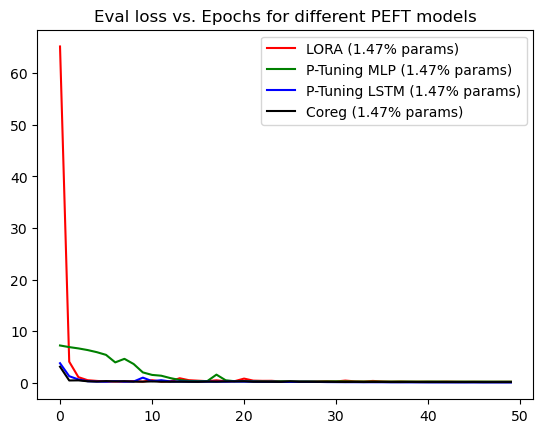

In [43]:
plt.figure()
plt.plot(lora_history, c='r', label='LORA (1.47% params)')
plt.plot(ptuning_mlp_history, c='g', label='P-Tuning MLP (1.47% params)')
plt.plot(ptuning_lstm_history, c='b', label='P-Tuning LSTM (1.47% params)')
# plt.plot([], c='y', label='Prompt Tuning (0.25% params) OOM')
plt.plot(coreg_history, c='k', label='Coreg (1.47% params)')
plt.title('Eval loss vs. Epochs for different PEFT models')
plt.legend()
plt.show()

In [45]:
coreg_configs = [CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
                                      num_views=view, 
                                      num_virtual_tokens=85,
                                      token_dim=1024,
                                      attention_dim=256) for view in [4,8,16,32,64]]


eval_results= []
for config in coreg_configs:
    eval_results.append(train(config))
    

trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=0: train_ppl=tensor(59.6720, device='cuda:0') train_epoch_loss=tensor(4.0889, device='cuda:0') eval_ppl=tensor(2.1705, device='cuda:0') eval_epoch_loss=tensor(0.7750, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=1: train_ppl=tensor(2.3664, device='cuda:0') train_epoch_loss=tensor(0.8614, device='cuda:0') eval_ppl=tensor(1.6512, device='cuda:0') eval_epoch_loss=tensor(0.5015, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=2: train_ppl=tensor(1.4786, device='cuda:0') train_epoch_loss=tensor(0.3911, device='cuda:0') eval_ppl=tensor(1.3185, device='cuda:0') eval_epoch_loss=tensor(0.2765, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=3: train_ppl=tensor(1.3133, device='cuda:0') train_epoch_loss=tensor(0.2725, device='cuda:0') eval_ppl=tensor(1.2703, device='cuda:0') eval_epoch_loss=tensor(0.2392, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=4: train_ppl=tensor(1.2500, device='cuda:0') train_epoch_loss=tensor(0.2232, device='cuda:0') eval_ppl=tensor(1.2190, device='cuda:0') eval_epoch_loss=tensor(0.1980, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=5: train_ppl=tensor(1.2384, device='cuda:0') train_epoch_loss=tensor(0.2139, device='cuda:0') eval_ppl=tensor(1.4029, device='cuda:0') eval_epoch_loss=tensor(0.3385, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=6: train_ppl=tensor(1.2779, device='cuda:0') train_epoch_loss=tensor(0.2452, device='cuda:0') eval_ppl=tensor(1.1984, device='cuda:0') eval_epoch_loss=tensor(0.1810, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=7: train_ppl=tensor(1.1802, device='cuda:0') train_epoch_loss=tensor(0.1657, device='cuda:0') eval_ppl=tensor(1.1901, device='cuda:0') eval_epoch_loss=tensor(0.1740, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=8: train_ppl=tensor(1.1839, device='cuda:0') train_epoch_loss=tensor(0.1689, device='cuda:0') eval_ppl=tensor(1.1620, device='cuda:0') eval_epoch_loss=tensor(0.1501, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=9: train_ppl=tensor(1.1961, device='cuda:0') train_epoch_loss=tensor(0.1791, device='cuda:0') eval_ppl=tensor(1.1488, device='cuda:0') eval_epoch_loss=tensor(0.1388, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=10: train_ppl=tensor(1.1576, device='cuda:0') train_epoch_loss=tensor(0.1464, device='cuda:0') eval_ppl=tensor(1.1618, device='cuda:0') eval_epoch_loss=tensor(0.1500, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=11: train_ppl=tensor(1.1613, device='cuda:0') train_epoch_loss=tensor(0.1495, device='cuda:0') eval_ppl=tensor(1.1273, device='cuda:0') eval_epoch_loss=tensor(0.1198, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=12: train_ppl=tensor(1.1596, device='cuda:0') train_epoch_loss=tensor(0.1480, device='cuda:0') eval_ppl=tensor(1.1134, device='cuda:0') eval_epoch_loss=tensor(0.1074, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=13: train_ppl=tensor(1.1519, device='cuda:0') train_epoch_loss=tensor(0.1414, device='cuda:0') eval_ppl=tensor(1.1449, device='cuda:0') eval_epoch_loss=tensor(0.1353, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=14: train_ppl=tensor(1.1501, device='cuda:0') train_epoch_loss=tensor(0.1398, device='cuda:0') eval_ppl=tensor(1.5184, device='cuda:0') eval_epoch_loss=tensor(0.4176, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=15: train_ppl=tensor(1.4184, device='cuda:0') train_epoch_loss=tensor(0.3495, device='cuda:0') eval_ppl=tensor(1.1610, device='cuda:0') eval_epoch_loss=tensor(0.1493, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=16: train_ppl=tensor(1.2245, device='cuda:0') train_epoch_loss=tensor(0.2025, device='cuda:0') eval_ppl=tensor(1.2576, device='cuda:0') eval_epoch_loss=tensor(0.2292, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=17: train_ppl=tensor(1.2168, device='cuda:0') train_epoch_loss=tensor(0.1962, device='cuda:0') eval_ppl=tensor(1.1204, device='cuda:0') eval_epoch_loss=tensor(0.1137, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=18: train_ppl=tensor(1.1438, device='cuda:0') train_epoch_loss=tensor(0.1344, device='cuda:0') eval_ppl=tensor(1.1060, device='cuda:0') eval_epoch_loss=tensor(0.1008, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=19: train_ppl=tensor(1.1097, device='cuda:0') train_epoch_loss=tensor(0.1041, device='cuda:0') eval_ppl=tensor(1.0825, device='cuda:0') eval_epoch_loss=tensor(0.0793, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=20: train_ppl=tensor(1.0869, device='cuda:0') train_epoch_loss=tensor(0.0833, device='cuda:0') eval_ppl=tensor(1.0784, device='cuda:0') eval_epoch_loss=tensor(0.0755, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=21: train_ppl=tensor(1.0587, device='cuda:0') train_epoch_loss=tensor(0.0570, device='cuda:0') eval_ppl=tensor(1.0841, device='cuda:0') eval_epoch_loss=tensor(0.0807, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=22: train_ppl=tensor(1.0618, device='cuda:0') train_epoch_loss=tensor(0.0599, device='cuda:0') eval_ppl=tensor(1.0803, device='cuda:0') eval_epoch_loss=tensor(0.0772, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=23: train_ppl=tensor(1.0508, device='cuda:0') train_epoch_loss=tensor(0.0496, device='cuda:0') eval_ppl=tensor(1.0414, device='cuda:0') eval_epoch_loss=tensor(0.0405, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=24: train_ppl=tensor(1.0479, device='cuda:0') train_epoch_loss=tensor(0.0468, device='cuda:0') eval_ppl=tensor(1.1236, device='cuda:0') eval_epoch_loss=tensor(0.1166, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=25: train_ppl=tensor(1.1146, device='cuda:0') train_epoch_loss=tensor(0.1085, device='cuda:0') eval_ppl=tensor(1.1456, device='cuda:0') eval_epoch_loss=tensor(0.1359, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=26: train_ppl=tensor(1.1228, device='cuda:0') train_epoch_loss=tensor(0.1159, device='cuda:0') eval_ppl=tensor(1.0808, device='cuda:0') eval_epoch_loss=tensor(0.0777, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=27: train_ppl=tensor(1.0725, device='cuda:0') train_epoch_loss=tensor(0.0700, device='cuda:0') eval_ppl=tensor(1.0670, device='cuda:0') eval_epoch_loss=tensor(0.0649, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=28: train_ppl=tensor(1.0825, device='cuda:0') train_epoch_loss=tensor(0.0793, device='cuda:0') eval_ppl=tensor(1.0353, device='cuda:0') eval_epoch_loss=tensor(0.0347, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=29: train_ppl=tensor(1.0335, device='cuda:0') train_epoch_loss=tensor(0.0330, device='cuda:0') eval_ppl=tensor(1.0321, device='cuda:0') eval_epoch_loss=tensor(0.0316, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=30: train_ppl=tensor(1.0200, device='cuda:0') train_epoch_loss=tensor(0.0198, device='cuda:0') eval_ppl=tensor(1.0241, device='cuda:0') eval_epoch_loss=tensor(0.0238, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=31: train_ppl=tensor(1.0153, device='cuda:0') train_epoch_loss=tensor(0.0152, device='cuda:0') eval_ppl=tensor(1.0162, device='cuda:0') eval_epoch_loss=tensor(0.0161, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.69it/s]


epoch=32: train_ppl=tensor(1.0190, device='cuda:0') train_epoch_loss=tensor(0.0188, device='cuda:0') eval_ppl=tensor(1.0146, device='cuda:0') eval_epoch_loss=tensor(0.0145, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=33: train_ppl=tensor(1.0215, device='cuda:0') train_epoch_loss=tensor(0.0213, device='cuda:0') eval_ppl=tensor(1.0123, device='cuda:0') eval_epoch_loss=tensor(0.0122, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=34: train_ppl=tensor(1.0232, device='cuda:0') train_epoch_loss=tensor(0.0230, device='cuda:0') eval_ppl=tensor(1.0075, device='cuda:0') eval_epoch_loss=tensor(0.0075, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.69it/s]


epoch=35: train_ppl=tensor(1.0125, device='cuda:0') train_epoch_loss=tensor(0.0124, device='cuda:0') eval_ppl=tensor(1.0102, device='cuda:0') eval_epoch_loss=tensor(0.0101, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=36: train_ppl=tensor(1.0081, device='cuda:0') train_epoch_loss=tensor(0.0081, device='cuda:0') eval_ppl=tensor(1.0048, device='cuda:0') eval_epoch_loss=tensor(0.0048, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=37: train_ppl=tensor(1.0047, device='cuda:0') train_epoch_loss=tensor(0.0047, device='cuda:0') eval_ppl=tensor(1.0045, device='cuda:0') eval_epoch_loss=tensor(0.0045, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=38: train_ppl=tensor(1.0040, device='cuda:0') train_epoch_loss=tensor(0.0040, device='cuda:0') eval_ppl=tensor(1.0030, device='cuda:0') eval_epoch_loss=tensor(0.0030, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=39: train_ppl=tensor(1.0029, device='cuda:0') train_epoch_loss=tensor(0.0029, device='cuda:0') eval_ppl=tensor(1.0027, device='cuda:0') eval_epoch_loss=tensor(0.0027, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=40: train_ppl=tensor(1.0027, device='cuda:0') train_epoch_loss=tensor(0.0027, device='cuda:0') eval_ppl=tensor(1.0025, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=41: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0022, device='cuda:0') eval_epoch_loss=tensor(0.0022, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=42: train_ppl=tensor(1.0026, device='cuda:0') train_epoch_loss=tensor(0.0026, device='cuda:0') eval_ppl=tensor(1.0021, device='cuda:0') eval_epoch_loss=tensor(0.0021, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=43: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=44: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=45: train_ppl=tensor(1.0020, device='cuda:0') train_epoch_loss=tensor(0.0020, device='cuda:0') eval_ppl=tensor(1.0018, device='cuda:0') eval_epoch_loss=tensor(0.0018, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=46: train_ppl=tensor(1.0017, device='cuda:0') train_epoch_loss=tensor(0.0017, device='cuda:0') eval_ppl=tensor(1.0018, device='cuda:0') eval_epoch_loss=tensor(0.0018, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=47: train_ppl=tensor(1.0017, device='cuda:0') train_epoch_loss=tensor(0.0017, device='cuda:0') eval_ppl=tensor(1.0018, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=48: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=49: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')
trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=0: train_ppl=tensor(46.6137, device='cuda:0') train_epoch_loss=tensor(3.8419, device='cuda:0') eval_ppl=tensor(1.4727, device='cuda:0') eval_epoch_loss=tensor(0.3871, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=1: train_ppl=tensor(1.3932, device='cuda:0') train_epoch_loss=tensor(0.3316, device='cuda:0') eval_ppl=tensor(1.2436, device='cuda:0') eval_epoch_loss=tensor(0.2180, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=2: train_ppl=tensor(1.3042, device='cuda:0') train_epoch_loss=tensor(0.2656, device='cuda:0') eval_ppl=tensor(1.2496, device='cuda:0') eval_epoch_loss=tensor(0.2228, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=3: train_ppl=tensor(1.2914, device='cuda:0') train_epoch_loss=tensor(0.2557, device='cuda:0') eval_ppl=tensor(1.2439, device='cuda:0') eval_epoch_loss=tensor(0.2182, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=4: train_ppl=tensor(1.1837, device='cuda:0') train_epoch_loss=tensor(0.1686, device='cuda:0') eval_ppl=tensor(1.2125, device='cuda:0') eval_epoch_loss=tensor(0.1926, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=5: train_ppl=tensor(1.1871, device='cuda:0') train_epoch_loss=tensor(0.1715, device='cuda:0') eval_ppl=tensor(1.2179, device='cuda:0') eval_epoch_loss=tensor(0.1971, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=6: train_ppl=tensor(1.1893, device='cuda:0') train_epoch_loss=tensor(0.1733, device='cuda:0') eval_ppl=tensor(1.2974, device='cuda:0') eval_epoch_loss=tensor(0.2603, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=7: train_ppl=tensor(1.3362, device='cuda:0') train_epoch_loss=tensor(0.2898, device='cuda:0') eval_ppl=tensor(1.3057, device='cuda:0') eval_epoch_loss=tensor(0.2668, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=8: train_ppl=tensor(1.2620, device='cuda:0') train_epoch_loss=tensor(0.2327, device='cuda:0') eval_ppl=tensor(1.4650, device='cuda:0') eval_epoch_loss=tensor(0.3818, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=9: train_ppl=tensor(1.3450, device='cuda:0') train_epoch_loss=tensor(0.2964, device='cuda:0') eval_ppl=tensor(1.1784, device='cuda:0') eval_epoch_loss=tensor(0.1641, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=10: train_ppl=tensor(1.1455, device='cuda:0') train_epoch_loss=tensor(0.1359, device='cuda:0') eval_ppl=tensor(1.1361, device='cuda:0') eval_epoch_loss=tensor(0.1276, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=11: train_ppl=tensor(1.1308, device='cuda:0') train_epoch_loss=tensor(0.1229, device='cuda:0') eval_ppl=tensor(1.0989, device='cuda:0') eval_epoch_loss=tensor(0.0943, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=12: train_ppl=tensor(1.0975, device='cuda:0') train_epoch_loss=tensor(0.0931, device='cuda:0') eval_ppl=tensor(1.0924, device='cuda:0') eval_epoch_loss=tensor(0.0884, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=13: train_ppl=tensor(1.1036, device='cuda:0') train_epoch_loss=tensor(0.0986, device='cuda:0') eval_ppl=tensor(1.1023, device='cuda:0') eval_epoch_loss=tensor(0.0974, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=14: train_ppl=tensor(1.1377, device='cuda:0') train_epoch_loss=tensor(0.1290, device='cuda:0') eval_ppl=tensor(1.1690, device='cuda:0') eval_epoch_loss=tensor(0.1561, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=15: train_ppl=tensor(1.1107, device='cuda:0') train_epoch_loss=tensor(0.1050, device='cuda:0') eval_ppl=tensor(1.0818, device='cuda:0') eval_epoch_loss=tensor(0.0786, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=16: train_ppl=tensor(1.0697, device='cuda:0') train_epoch_loss=tensor(0.0674, device='cuda:0') eval_ppl=tensor(1.0688, device='cuda:0') eval_epoch_loss=tensor(0.0666, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=17: train_ppl=tensor(1.0780, device='cuda:0') train_epoch_loss=tensor(0.0751, device='cuda:0') eval_ppl=tensor(1.0558, device='cuda:0') eval_epoch_loss=tensor(0.0543, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=18: train_ppl=tensor(1.0645, device='cuda:0') train_epoch_loss=tensor(0.0625, device='cuda:0') eval_ppl=tensor(1.0499, device='cuda:0') eval_epoch_loss=tensor(0.0487, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=19: train_ppl=tensor(1.0757, device='cuda:0') train_epoch_loss=tensor(0.0730, device='cuda:0') eval_ppl=tensor(1.0417, device='cuda:0') eval_epoch_loss=tensor(0.0408, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=20: train_ppl=tensor(1.0299, device='cuda:0') train_epoch_loss=tensor(0.0295, device='cuda:0') eval_ppl=tensor(1.0462, device='cuda:0') eval_epoch_loss=tensor(0.0452, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=21: train_ppl=tensor(1.0321, device='cuda:0') train_epoch_loss=tensor(0.0316, device='cuda:0') eval_ppl=tensor(1.0241, device='cuda:0') eval_epoch_loss=tensor(0.0238, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=22: train_ppl=tensor(1.0239, device='cuda:0') train_epoch_loss=tensor(0.0236, device='cuda:0') eval_ppl=tensor(1.0351, device='cuda:0') eval_epoch_loss=tensor(0.0345, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=23: train_ppl=tensor(1.0253, device='cuda:0') train_epoch_loss=tensor(0.0250, device='cuda:0') eval_ppl=tensor(1.0176, device='cuda:0') eval_epoch_loss=tensor(0.0175, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=24: train_ppl=tensor(1.0166, device='cuda:0') train_epoch_loss=tensor(0.0165, device='cuda:0') eval_ppl=tensor(1.0189, device='cuda:0') eval_epoch_loss=tensor(0.0188, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=25: train_ppl=tensor(1.0176, device='cuda:0') train_epoch_loss=tensor(0.0174, device='cuda:0') eval_ppl=tensor(1.0101, device='cuda:0') eval_epoch_loss=tensor(0.0101, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=26: train_ppl=tensor(1.0137, device='cuda:0') train_epoch_loss=tensor(0.0137, device='cuda:0') eval_ppl=tensor(1.0084, device='cuda:0') eval_epoch_loss=tensor(0.0083, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=27: train_ppl=tensor(1.0099, device='cuda:0') train_epoch_loss=tensor(0.0098, device='cuda:0') eval_ppl=tensor(1.0072, device='cuda:0') eval_epoch_loss=tensor(0.0072, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=28: train_ppl=tensor(1.0071, device='cuda:0') train_epoch_loss=tensor(0.0070, device='cuda:0') eval_ppl=tensor(1.0064, device='cuda:0') eval_epoch_loss=tensor(0.0064, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=29: train_ppl=tensor(1.0071, device='cuda:0') train_epoch_loss=tensor(0.0071, device='cuda:0') eval_ppl=tensor(1.0057, device='cuda:0') eval_epoch_loss=tensor(0.0057, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=30: train_ppl=tensor(1.0052, device='cuda:0') train_epoch_loss=tensor(0.0052, device='cuda:0') eval_ppl=tensor(1.0061, device='cuda:0') eval_epoch_loss=tensor(0.0061, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=31: train_ppl=tensor(1.0055, device='cuda:0') train_epoch_loss=tensor(0.0055, device='cuda:0') eval_ppl=tensor(1.0042, device='cuda:0') eval_epoch_loss=tensor(0.0041, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=32: train_ppl=tensor(1.0040, device='cuda:0') train_epoch_loss=tensor(0.0040, device='cuda:0') eval_ppl=tensor(1.0038, device='cuda:0') eval_epoch_loss=tensor(0.0038, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=33: train_ppl=tensor(1.0033, device='cuda:0') train_epoch_loss=tensor(0.0033, device='cuda:0') eval_ppl=tensor(1.0037, device='cuda:0') eval_epoch_loss=tensor(0.0037, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=34: train_ppl=tensor(1.0030, device='cuda:0') train_epoch_loss=tensor(0.0030, device='cuda:0') eval_ppl=tensor(1.0032, device='cuda:0') eval_epoch_loss=tensor(0.0032, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=35: train_ppl=tensor(1.0027, device='cuda:0') train_epoch_loss=tensor(0.0027, device='cuda:0') eval_ppl=tensor(1.0030, device='cuda:0') eval_epoch_loss=tensor(0.0030, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=36: train_ppl=tensor(1.0026, device='cuda:0') train_epoch_loss=tensor(0.0026, device='cuda:0') eval_ppl=tensor(1.0028, device='cuda:0') eval_epoch_loss=tensor(0.0028, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=37: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0027, device='cuda:0') eval_epoch_loss=tensor(0.0027, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=38: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0026, device='cuda:0') eval_epoch_loss=tensor(0.0026, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=39: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=40: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=41: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0023, device='cuda:0') eval_epoch_loss=tensor(0.0023, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=42: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0022, device='cuda:0') eval_epoch_loss=tensor(0.0022, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=43: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0021, device='cuda:0') eval_epoch_loss=tensor(0.0021, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=44: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0021, device='cuda:0') eval_epoch_loss=tensor(0.0021, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=45: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=46: train_ppl=tensor(1.0020, device='cuda:0') train_epoch_loss=tensor(0.0020, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=47: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=48: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=49: train_ppl=tensor(1.0020, device='cuda:0') train_epoch_loss=tensor(0.0020, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')
trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=0: train_ppl=tensor(360.1638, device='cuda:0') train_epoch_loss=tensor(5.8866, device='cuda:0') eval_ppl=tensor(276.3917, device='cuda:0') eval_epoch_loss=tensor(5.6218, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=1: train_ppl=tensor(25.3598, device='cuda:0') train_epoch_loss=tensor(3.2332, device='cuda:0') eval_ppl=tensor(3.7117, device='cuda:0') eval_epoch_loss=tensor(1.3115, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=2: train_ppl=tensor(2.4734, device='cuda:0') train_epoch_loss=tensor(0.9056, device='cuda:0') eval_ppl=tensor(1.5631, device='cuda:0') eval_epoch_loss=tensor(0.4467, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=3: train_ppl=tensor(1.4135, device='cuda:0') train_epoch_loss=tensor(0.3461, device='cuda:0') eval_ppl=tensor(1.3496, device='cuda:0') eval_epoch_loss=tensor(0.2998, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=4: train_ppl=tensor(1.3130, device='cuda:0') train_epoch_loss=tensor(0.2723, device='cuda:0') eval_ppl=tensor(1.2701, device='cuda:0') eval_epoch_loss=tensor(0.2391, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=5: train_ppl=tensor(1.2301, device='cuda:0') train_epoch_loss=tensor(0.2071, device='cuda:0') eval_ppl=tensor(1.2309, device='cuda:0') eval_epoch_loss=tensor(0.2078, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=6: train_ppl=tensor(1.2352, device='cuda:0') train_epoch_loss=tensor(0.2112, device='cuda:0') eval_ppl=tensor(1.2231, device='cuda:0') eval_epoch_loss=tensor(0.2014, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=7: train_ppl=tensor(1.2275, device='cuda:0') train_epoch_loss=tensor(0.2050, device='cuda:0') eval_ppl=tensor(1.2278, device='cuda:0') eval_epoch_loss=tensor(0.2053, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=8: train_ppl=tensor(1.2285, device='cuda:0') train_epoch_loss=tensor(0.2058, device='cuda:0') eval_ppl=tensor(1.4014, device='cuda:0') eval_epoch_loss=tensor(0.3374, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=9: train_ppl=tensor(1.4251, device='cuda:0') train_epoch_loss=tensor(0.3543, device='cuda:0') eval_ppl=tensor(1.2417, device='cuda:0') eval_epoch_loss=tensor(0.2165, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=10: train_ppl=tensor(1.3574, device='cuda:0') train_epoch_loss=tensor(0.3055, device='cuda:0') eval_ppl=tensor(1.3026, device='cuda:0') eval_epoch_loss=tensor(0.2644, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=11: train_ppl=tensor(1.2620, device='cuda:0') train_epoch_loss=tensor(0.2327, device='cuda:0') eval_ppl=tensor(1.2574, device='cuda:0') eval_epoch_loss=tensor(0.2290, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=12: train_ppl=tensor(1.2448, device='cuda:0') train_epoch_loss=tensor(0.2190, device='cuda:0') eval_ppl=tensor(1.2271, device='cuda:0') eval_epoch_loss=tensor(0.2047, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=13: train_ppl=tensor(1.2020, device='cuda:0') train_epoch_loss=tensor(0.1840, device='cuda:0') eval_ppl=tensor(1.2236, device='cuda:0') eval_epoch_loss=tensor(0.2018, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=14: train_ppl=tensor(1.2264, device='cuda:0') train_epoch_loss=tensor(0.2041, device='cuda:0') eval_ppl=tensor(1.2034, device='cuda:0') eval_epoch_loss=tensor(0.1851, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=15: train_ppl=tensor(1.2075, device='cuda:0') train_epoch_loss=tensor(0.1886, device='cuda:0') eval_ppl=tensor(1.2075, device='cuda:0') eval_epoch_loss=tensor(0.1886, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=16: train_ppl=tensor(1.2741, device='cuda:0') train_epoch_loss=tensor(0.2423, device='cuda:0') eval_ppl=tensor(1.1815, device='cuda:0') eval_epoch_loss=tensor(0.1668, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=17: train_ppl=tensor(1.1995, device='cuda:0') train_epoch_loss=tensor(0.1819, device='cuda:0') eval_ppl=tensor(1.2353, device='cuda:0') eval_epoch_loss=tensor(0.2113, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=18: train_ppl=tensor(1.2248, device='cuda:0') train_epoch_loss=tensor(0.2027, device='cuda:0') eval_ppl=tensor(1.2103, device='cuda:0') eval_epoch_loss=tensor(0.1908, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=19: train_ppl=tensor(1.1926, device='cuda:0') train_epoch_loss=tensor(0.1761, device='cuda:0') eval_ppl=tensor(1.2118, device='cuda:0') eval_epoch_loss=tensor(0.1921, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=20: train_ppl=tensor(1.1807, device='cuda:0') train_epoch_loss=tensor(0.1661, device='cuda:0') eval_ppl=tensor(1.2054, device='cuda:0') eval_epoch_loss=tensor(0.1868, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=21: train_ppl=tensor(1.1944, device='cuda:0') train_epoch_loss=tensor(0.1777, device='cuda:0') eval_ppl=tensor(1.2029, device='cuda:0') eval_epoch_loss=tensor(0.1847, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=22: train_ppl=tensor(1.1627, device='cuda:0') train_epoch_loss=tensor(0.1507, device='cuda:0') eval_ppl=tensor(1.1581, device='cuda:0') eval_epoch_loss=tensor(0.1468, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=23: train_ppl=tensor(1.1503, device='cuda:0') train_epoch_loss=tensor(0.1400, device='cuda:0') eval_ppl=tensor(1.3159, device='cuda:0') eval_epoch_loss=tensor(0.2745, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=24: train_ppl=tensor(1.2093, device='cuda:0') train_epoch_loss=tensor(0.1901, device='cuda:0') eval_ppl=tensor(1.1700, device='cuda:0') eval_epoch_loss=tensor(0.1570, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=25: train_ppl=tensor(1.1542, device='cuda:0') train_epoch_loss=tensor(0.1434, device='cuda:0') eval_ppl=tensor(1.1511, device='cuda:0') eval_epoch_loss=tensor(0.1407, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=26: train_ppl=tensor(1.1428, device='cuda:0') train_epoch_loss=tensor(0.1335, device='cuda:0') eval_ppl=tensor(1.1211, device='cuda:0') eval_epoch_loss=tensor(0.1143, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=27: train_ppl=tensor(1.1549, device='cuda:0') train_epoch_loss=tensor(0.1441, device='cuda:0') eval_ppl=tensor(1.1228, device='cuda:0') eval_epoch_loss=tensor(0.1158, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=28: train_ppl=tensor(1.1734, device='cuda:0') train_epoch_loss=tensor(0.1599, device='cuda:0') eval_ppl=tensor(1.1005, device='cuda:0') eval_epoch_loss=tensor(0.0958, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=29: train_ppl=tensor(1.1226, device='cuda:0') train_epoch_loss=tensor(0.1156, device='cuda:0') eval_ppl=tensor(1.1105, device='cuda:0') eval_epoch_loss=tensor(0.1048, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=30: train_ppl=tensor(1.1085, device='cuda:0') train_epoch_loss=tensor(0.1030, device='cuda:0') eval_ppl=tensor(1.0814, device='cuda:0') eval_epoch_loss=tensor(0.0783, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=31: train_ppl=tensor(1.0863, device='cuda:0') train_epoch_loss=tensor(0.0828, device='cuda:0') eval_ppl=tensor(1.0725, device='cuda:0') eval_epoch_loss=tensor(0.0700, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=32: train_ppl=tensor(1.1182, device='cuda:0') train_epoch_loss=tensor(0.1117, device='cuda:0') eval_ppl=tensor(1.0643, device='cuda:0') eval_epoch_loss=tensor(0.0623, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=33: train_ppl=tensor(1.0893, device='cuda:0') train_epoch_loss=tensor(0.0856, device='cuda:0') eval_ppl=tensor(1.0685, device='cuda:0') eval_epoch_loss=tensor(0.0662, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=34: train_ppl=tensor(1.0673, device='cuda:0') train_epoch_loss=tensor(0.0651, device='cuda:0') eval_ppl=tensor(1.0635, device='cuda:0') eval_epoch_loss=tensor(0.0615, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=35: train_ppl=tensor(1.0591, device='cuda:0') train_epoch_loss=tensor(0.0574, device='cuda:0') eval_ppl=tensor(1.0496, device='cuda:0') eval_epoch_loss=tensor(0.0484, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=36: train_ppl=tensor(1.0500, device='cuda:0') train_epoch_loss=tensor(0.0488, device='cuda:0') eval_ppl=tensor(1.0448, device='cuda:0') eval_epoch_loss=tensor(0.0438, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=37: train_ppl=tensor(1.0402, device='cuda:0') train_epoch_loss=tensor(0.0394, device='cuda:0') eval_ppl=tensor(1.0398, device='cuda:0') eval_epoch_loss=tensor(0.0391, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=38: train_ppl=tensor(1.0451, device='cuda:0') train_epoch_loss=tensor(0.0441, device='cuda:0') eval_ppl=tensor(1.0391, device='cuda:0') eval_epoch_loss=tensor(0.0384, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=39: train_ppl=tensor(1.0428, device='cuda:0') train_epoch_loss=tensor(0.0419, device='cuda:0') eval_ppl=tensor(1.0323, device='cuda:0') eval_epoch_loss=tensor(0.0318, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=40: train_ppl=tensor(1.0465, device='cuda:0') train_epoch_loss=tensor(0.0455, device='cuda:0') eval_ppl=tensor(1.0332, device='cuda:0') eval_epoch_loss=tensor(0.0327, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=41: train_ppl=tensor(1.0399, device='cuda:0') train_epoch_loss=tensor(0.0391, device='cuda:0') eval_ppl=tensor(1.0284, device='cuda:0') eval_epoch_loss=tensor(0.0281, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=42: train_ppl=tensor(1.0386, device='cuda:0') train_epoch_loss=tensor(0.0378, device='cuda:0') eval_ppl=tensor(1.0274, device='cuda:0') eval_epoch_loss=tensor(0.0271, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=43: train_ppl=tensor(1.0313, device='cuda:0') train_epoch_loss=tensor(0.0308, device='cuda:0') eval_ppl=tensor(1.0320, device='cuda:0') eval_epoch_loss=tensor(0.0315, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=44: train_ppl=tensor(1.0270, device='cuda:0') train_epoch_loss=tensor(0.0267, device='cuda:0') eval_ppl=tensor(1.0222, device='cuda:0') eval_epoch_loss=tensor(0.0220, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=45: train_ppl=tensor(1.0260, device='cuda:0') train_epoch_loss=tensor(0.0257, device='cuda:0') eval_ppl=tensor(1.0227, device='cuda:0') eval_epoch_loss=tensor(0.0224, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=46: train_ppl=tensor(1.0188, device='cuda:0') train_epoch_loss=tensor(0.0186, device='cuda:0') eval_ppl=tensor(1.0218, device='cuda:0') eval_epoch_loss=tensor(0.0216, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=47: train_ppl=tensor(1.0200, device='cuda:0') train_epoch_loss=tensor(0.0198, device='cuda:0') eval_ppl=tensor(1.0214, device='cuda:0') eval_epoch_loss=tensor(0.0212, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=48: train_ppl=tensor(1.0171, device='cuda:0') train_epoch_loss=tensor(0.0170, device='cuda:0') eval_ppl=tensor(1.0187, device='cuda:0') eval_epoch_loss=tensor(0.0185, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=49: train_ppl=tensor(1.0194, device='cuda:0') train_epoch_loss=tensor(0.0192, device='cuda:0') eval_ppl=tensor(1.0181, device='cuda:0') eval_epoch_loss=tensor(0.0179, device='cuda:0')
trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=0: train_ppl=tensor(163.7475, device='cuda:0') train_epoch_loss=tensor(5.0983, device='cuda:0') eval_ppl=tensor(5.2318, device='cuda:0') eval_epoch_loss=tensor(1.6548, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=1: train_ppl=tensor(2.7842, device='cuda:0') train_epoch_loss=tensor(1.0240, device='cuda:0') eval_ppl=tensor(1.4262, device='cuda:0') eval_epoch_loss=tensor(0.3550, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=2: train_ppl=tensor(1.3713, device='cuda:0') train_epoch_loss=tensor(0.3157, device='cuda:0') eval_ppl=tensor(1.3417, device='cuda:0') eval_epoch_loss=tensor(0.2939, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=3: train_ppl=tensor(1.2935, device='cuda:0') train_epoch_loss=tensor(0.2573, device='cuda:0') eval_ppl=tensor(1.6302, device='cuda:0') eval_epoch_loss=tensor(0.4887, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=4: train_ppl=tensor(1.3729, device='cuda:0') train_epoch_loss=tensor(0.3169, device='cuda:0') eval_ppl=tensor(1.2647, device='cuda:0') eval_epoch_loss=tensor(0.2348, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=5: train_ppl=tensor(1.2317, device='cuda:0') train_epoch_loss=tensor(0.2084, device='cuda:0') eval_ppl=tensor(1.1998, device='cuda:0') eval_epoch_loss=tensor(0.1821, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=6: train_ppl=tensor(1.1564, device='cuda:0') train_epoch_loss=tensor(0.1453, device='cuda:0') eval_ppl=tensor(1.3266, device='cuda:0') eval_epoch_loss=tensor(0.2826, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=7: train_ppl=tensor(1.3002, device='cuda:0') train_epoch_loss=tensor(0.2626, device='cuda:0') eval_ppl=tensor(1.4804, device='cuda:0') eval_epoch_loss=tensor(0.3923, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=8: train_ppl=tensor(1.3158, device='cuda:0') train_epoch_loss=tensor(0.2744, device='cuda:0') eval_ppl=tensor(1.1988, device='cuda:0') eval_epoch_loss=tensor(0.1814, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=9: train_ppl=tensor(1.2334, device='cuda:0') train_epoch_loss=tensor(0.2098, device='cuda:0') eval_ppl=tensor(1.2588, device='cuda:0') eval_epoch_loss=tensor(0.2301, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=10: train_ppl=tensor(1.2872, device='cuda:0') train_epoch_loss=tensor(0.2524, device='cuda:0') eval_ppl=tensor(1.3111, device='cuda:0') eval_epoch_loss=tensor(0.2709, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=11: train_ppl=tensor(1.2921, device='cuda:0') train_epoch_loss=tensor(0.2563, device='cuda:0') eval_ppl=tensor(1.2237, device='cuda:0') eval_epoch_loss=tensor(0.2018, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=12: train_ppl=tensor(1.2239, device='cuda:0') train_epoch_loss=tensor(0.2020, device='cuda:0') eval_ppl=tensor(1.1394, device='cuda:0') eval_epoch_loss=tensor(0.1305, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=13: train_ppl=tensor(1.1657, device='cuda:0') train_epoch_loss=tensor(0.1534, device='cuda:0') eval_ppl=tensor(1.1362, device='cuda:0') eval_epoch_loss=tensor(0.1277, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=14: train_ppl=tensor(1.1105, device='cuda:0') train_epoch_loss=tensor(0.1048, device='cuda:0') eval_ppl=tensor(1.1278, device='cuda:0') eval_epoch_loss=tensor(0.1202, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=15: train_ppl=tensor(1.1107, device='cuda:0') train_epoch_loss=tensor(0.1050, device='cuda:0') eval_ppl=tensor(1.0867, device='cuda:0') eval_epoch_loss=tensor(0.0831, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=16: train_ppl=tensor(1.0863, device='cuda:0') train_epoch_loss=tensor(0.0828, device='cuda:0') eval_ppl=tensor(1.0723, device='cuda:0') eval_epoch_loss=tensor(0.0698, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=17: train_ppl=tensor(1.0531, device='cuda:0') train_epoch_loss=tensor(0.0517, device='cuda:0') eval_ppl=tensor(1.0407, device='cuda:0') eval_epoch_loss=tensor(0.0399, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=18: train_ppl=tensor(1.0423, device='cuda:0') train_epoch_loss=tensor(0.0414, device='cuda:0') eval_ppl=tensor(1.0617, device='cuda:0') eval_epoch_loss=tensor(0.0598, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=19: train_ppl=tensor(1.0495, device='cuda:0') train_epoch_loss=tensor(0.0484, device='cuda:0') eval_ppl=tensor(1.0264, device='cuda:0') eval_epoch_loss=tensor(0.0260, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=20: train_ppl=tensor(1.0436, device='cuda:0') train_epoch_loss=tensor(0.0427, device='cuda:0') eval_ppl=tensor(1.1000, device='cuda:0') eval_epoch_loss=tensor(0.0953, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=21: train_ppl=tensor(1.1173, device='cuda:0') train_epoch_loss=tensor(0.1109, device='cuda:0') eval_ppl=tensor(1.1877, device='cuda:0') eval_epoch_loss=tensor(0.1720, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=22: train_ppl=tensor(1.1529, device='cuda:0') train_epoch_loss=tensor(0.1423, device='cuda:0') eval_ppl=tensor(1.2148, device='cuda:0') eval_epoch_loss=tensor(0.1946, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=23: train_ppl=tensor(1.1641, device='cuda:0') train_epoch_loss=tensor(0.1520, device='cuda:0') eval_ppl=tensor(1.0762, device='cuda:0') eval_epoch_loss=tensor(0.0734, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=24: train_ppl=tensor(1.0734, device='cuda:0') train_epoch_loss=tensor(0.0708, device='cuda:0') eval_ppl=tensor(1.0556, device='cuda:0') eval_epoch_loss=tensor(0.0541, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=25: train_ppl=tensor(1.0455, device='cuda:0') train_epoch_loss=tensor(0.0445, device='cuda:0') eval_ppl=tensor(1.0408, device='cuda:0') eval_epoch_loss=tensor(0.0399, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=26: train_ppl=tensor(1.0275, device='cuda:0') train_epoch_loss=tensor(0.0272, device='cuda:0') eval_ppl=tensor(1.0245, device='cuda:0') eval_epoch_loss=tensor(0.0242, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=27: train_ppl=tensor(1.0258, device='cuda:0') train_epoch_loss=tensor(0.0255, device='cuda:0') eval_ppl=tensor(1.0240, device='cuda:0') eval_epoch_loss=tensor(0.0238, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=28: train_ppl=tensor(1.0155, device='cuda:0') train_epoch_loss=tensor(0.0154, device='cuda:0') eval_ppl=tensor(1.0340, device='cuda:0') eval_epoch_loss=tensor(0.0334, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=29: train_ppl=tensor(1.0143, device='cuda:0') train_epoch_loss=tensor(0.0142, device='cuda:0') eval_ppl=tensor(1.0203, device='cuda:0') eval_epoch_loss=tensor(0.0200, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=30: train_ppl=tensor(1.0173, device='cuda:0') train_epoch_loss=tensor(0.0172, device='cuda:0') eval_ppl=tensor(1.0152, device='cuda:0') eval_epoch_loss=tensor(0.0151, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=31: train_ppl=tensor(1.0103, device='cuda:0') train_epoch_loss=tensor(0.0102, device='cuda:0') eval_ppl=tensor(1.0071, device='cuda:0') eval_epoch_loss=tensor(0.0071, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=32: train_ppl=tensor(1.0107, device='cuda:0') train_epoch_loss=tensor(0.0106, device='cuda:0') eval_ppl=tensor(1.0052, device='cuda:0') eval_epoch_loss=tensor(0.0051, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=33: train_ppl=tensor(1.0059, device='cuda:0') train_epoch_loss=tensor(0.0059, device='cuda:0') eval_ppl=tensor(1.0073, device='cuda:0') eval_epoch_loss=tensor(0.0073, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=34: train_ppl=tensor(1.0046, device='cuda:0') train_epoch_loss=tensor(0.0045, device='cuda:0') eval_ppl=tensor(1.0044, device='cuda:0') eval_epoch_loss=tensor(0.0044, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=35: train_ppl=tensor(1.0044, device='cuda:0') train_epoch_loss=tensor(0.0044, device='cuda:0') eval_ppl=tensor(1.0044, device='cuda:0') eval_epoch_loss=tensor(0.0044, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=36: train_ppl=tensor(1.0028, device='cuda:0') train_epoch_loss=tensor(0.0028, device='cuda:0') eval_ppl=tensor(1.0041, device='cuda:0') eval_epoch_loss=tensor(0.0041, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=37: train_ppl=tensor(1.0029, device='cuda:0') train_epoch_loss=tensor(0.0029, device='cuda:0') eval_ppl=tensor(1.0039, device='cuda:0') eval_epoch_loss=tensor(0.0039, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=38: train_ppl=tensor(1.0033, device='cuda:0') train_epoch_loss=tensor(0.0033, device='cuda:0') eval_ppl=tensor(1.0032, device='cuda:0') eval_epoch_loss=tensor(0.0032, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=39: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0031, device='cuda:0') eval_epoch_loss=tensor(0.0031, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=40: train_ppl=tensor(1.0028, device='cuda:0') train_epoch_loss=tensor(0.0028, device='cuda:0') eval_ppl=tensor(1.0030, device='cuda:0') eval_epoch_loss=tensor(0.0030, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=41: train_ppl=tensor(1.0031, device='cuda:0') train_epoch_loss=tensor(0.0031, device='cuda:0') eval_ppl=tensor(1.0029, device='cuda:0') eval_epoch_loss=tensor(0.0029, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=42: train_ppl=tensor(1.0029, device='cuda:0') train_epoch_loss=tensor(0.0029, device='cuda:0') eval_ppl=tensor(1.0028, device='cuda:0') eval_epoch_loss=tensor(0.0028, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=43: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0026, device='cuda:0') eval_epoch_loss=tensor(0.0026, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=44: train_ppl=tensor(1.0020, device='cuda:0') train_epoch_loss=tensor(0.0020, device='cuda:0') eval_ppl=tensor(1.0025, device='cuda:0') eval_epoch_loss=tensor(0.0025, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=45: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=46: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=47: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=48: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=49: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')
trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=0: train_ppl=tensor(55.5827, device='cuda:0') train_epoch_loss=tensor(4.0179, device='cuda:0') eval_ppl=tensor(2.2081, device='cuda:0') eval_epoch_loss=tensor(0.7921, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=1: train_ppl=tensor(1.4032, device='cuda:0') train_epoch_loss=tensor(0.3388, device='cuda:0') eval_ppl=tensor(1.9860, device='cuda:0') eval_epoch_loss=tensor(0.6861, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=2: train_ppl=tensor(1.4107, device='cuda:0') train_epoch_loss=tensor(0.3441, device='cuda:0') eval_ppl=tensor(1.2753, device='cuda:0') eval_epoch_loss=tensor(0.2432, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=3: train_ppl=tensor(1.3632, device='cuda:0') train_epoch_loss=tensor(0.3098, device='cuda:0') eval_ppl=tensor(1.3377, device='cuda:0') eval_epoch_loss=tensor(0.2910, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=4: train_ppl=tensor(1.2918, device='cuda:0') train_epoch_loss=tensor(0.2561, device='cuda:0') eval_ppl=tensor(1.2879, device='cuda:0') eval_epoch_loss=tensor(0.2530, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=5: train_ppl=tensor(1.2820, device='cuda:0') train_epoch_loss=tensor(0.2485, device='cuda:0') eval_ppl=tensor(1.1749, device='cuda:0') eval_epoch_loss=tensor(0.1612, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=6: train_ppl=tensor(1.2441, device='cuda:0') train_epoch_loss=tensor(0.2184, device='cuda:0') eval_ppl=tensor(1.1562, device='cuda:0') eval_epoch_loss=tensor(0.1452, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=7: train_ppl=tensor(1.1600, device='cuda:0') train_epoch_loss=tensor(0.1484, device='cuda:0') eval_ppl=tensor(1.1895, device='cuda:0') eval_epoch_loss=tensor(0.1735, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=8: train_ppl=tensor(1.1649, device='cuda:0') train_epoch_loss=tensor(0.1526, device='cuda:0') eval_ppl=tensor(1.1095, device='cuda:0') eval_epoch_loss=tensor(0.1039, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=9: train_ppl=tensor(1.1270, device='cuda:0') train_epoch_loss=tensor(0.1196, device='cuda:0') eval_ppl=tensor(1.1157, device='cuda:0') eval_epoch_loss=tensor(0.1095, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=10: train_ppl=tensor(1.1566, device='cuda:0') train_epoch_loss=tensor(0.1455, device='cuda:0') eval_ppl=tensor(1.1085, device='cuda:0') eval_epoch_loss=tensor(0.1030, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=11: train_ppl=tensor(1.1175, device='cuda:0') train_epoch_loss=tensor(0.1111, device='cuda:0') eval_ppl=tensor(1.0831, device='cuda:0') eval_epoch_loss=tensor(0.0798, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=12: train_ppl=tensor(1.1176, device='cuda:0') train_epoch_loss=tensor(0.1112, device='cuda:0') eval_ppl=tensor(1.0580, device='cuda:0') eval_epoch_loss=tensor(0.0564, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=13: train_ppl=tensor(1.0783, device='cuda:0') train_epoch_loss=tensor(0.0754, device='cuda:0') eval_ppl=tensor(1.0500, device='cuda:0') eval_epoch_loss=tensor(0.0488, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=14: train_ppl=tensor(1.0576, device='cuda:0') train_epoch_loss=tensor(0.0560, device='cuda:0') eval_ppl=tensor(1.0469, device='cuda:0') eval_epoch_loss=tensor(0.0458, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=15: train_ppl=tensor(1.0353, device='cuda:0') train_epoch_loss=tensor(0.0347, device='cuda:0') eval_ppl=tensor(1.0322, device='cuda:0') eval_epoch_loss=tensor(0.0316, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=16: train_ppl=tensor(1.0377, device='cuda:0') train_epoch_loss=tensor(0.0370, device='cuda:0') eval_ppl=tensor(1.0334, device='cuda:0') eval_epoch_loss=tensor(0.0328, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=17: train_ppl=tensor(1.0304, device='cuda:0') train_epoch_loss=tensor(0.0300, device='cuda:0') eval_ppl=tensor(1.0165, device='cuda:0') eval_epoch_loss=tensor(0.0163, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=18: train_ppl=tensor(1.0160, device='cuda:0') train_epoch_loss=tensor(0.0158, device='cuda:0') eval_ppl=tensor(1.0096, device='cuda:0') eval_epoch_loss=tensor(0.0096, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=19: train_ppl=tensor(1.0086, device='cuda:0') train_epoch_loss=tensor(0.0086, device='cuda:0') eval_ppl=tensor(1.0072, device='cuda:0') eval_epoch_loss=tensor(0.0072, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=20: train_ppl=tensor(1.0066, device='cuda:0') train_epoch_loss=tensor(0.0065, device='cuda:0') eval_ppl=tensor(1.0038, device='cuda:0') eval_epoch_loss=tensor(0.0038, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=21: train_ppl=tensor(1.0057, device='cuda:0') train_epoch_loss=tensor(0.0057, device='cuda:0') eval_ppl=tensor(1.0049, device='cuda:0') eval_epoch_loss=tensor(0.0049, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=22: train_ppl=tensor(1.0038, device='cuda:0') train_epoch_loss=tensor(0.0038, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=23: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0022, device='cuda:0') eval_epoch_loss=tensor(0.0022, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=24: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0016, device='cuda:0') eval_epoch_loss=tensor(0.0016, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=25: train_ppl=tensor(1.0015, device='cuda:0') train_epoch_loss=tensor(0.0015, device='cuda:0') eval_ppl=tensor(1.0011, device='cuda:0') eval_epoch_loss=tensor(0.0011, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=26: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0010, device='cuda:0') eval_epoch_loss=tensor(0.0010, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=27: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=28: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=29: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=30: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=31: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=32: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=33: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=34: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=35: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=36: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=37: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=38: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=39: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=40: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=41: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


epoch=42: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


epoch=43: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=44: train_ppl=tensor(1.0002, device='cuda:0') train_epoch_loss=tensor(0.0002, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=45: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=46: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=47: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=48: train_ppl=tensor(1.0002, device='cuda:0') train_epoch_loss=tensor(0.0002, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]

epoch=49: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


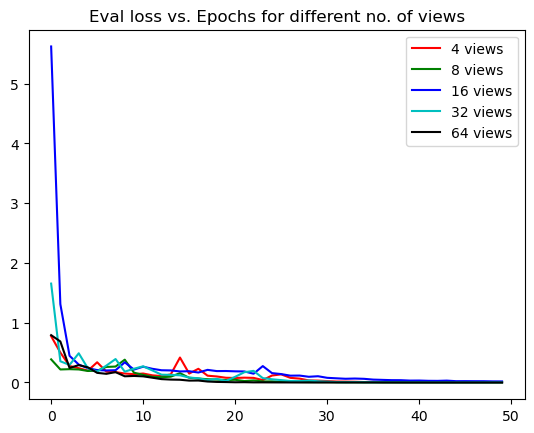

In [52]:
plt.figure()

colors = {4:'r',8:'g',16:'b',32:'c',64:'k'}
i=0
for view in [4,8,16,32,64]:
    plt.plot(eval_results[i], c=colors[view], label=f'{view} views')
    i+=1

plt.title('Eval loss vs. Epochs for different no. of views')

plt.legend()
plt.show()

In [30]:
model.eval()
i = 27
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]} Label : ', return_tensors="pt")
print(dataset["test"][i]["Tweet text"])
print(inputs)

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10, eos_token_id=3
    )
    print(outputs)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

@SquareUK When will Canada get this!?
{'input_ids': tensor([[227985,   5484,    915,   2566, 147586,  38943,  13929,   2152,  17502,
           2213,   1119, 192136,  77658,    915,    210]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[227985,   5484,    915,   2566, 147586,  38943,  13929,   2152,  17502,
           2213,   1119, 192136,  77658,    915,    210,   1936, 106863,      2,
             31,  43907,  20321,  97547,     29,   1387,   6747]],
       device='cuda:0')
['Tweet text : @SquareUK When will Canada get this!? Label : no complaint<b>Note</b>: The following']


In [31]:
# saving model
peft_model_id = f"{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}"
model.save_pretrained(peft_model_id)

In [32]:
ckpt = f"{peft_model_id}/adapter_model.bin"
!du -h $ckpt

84K	bigscience/bloomz-560m_COREG_PROMPT_TUNING_CAUSAL_LM/adapter_model.bin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
from peft import PeftModel, PeftConfig

peft_model_id = f"{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}"

config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, peft_model_id)

In [34]:
model.to(device)
model.eval()
i = 43
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]} Label : ', return_tensors="pt")
print(dataset["test"][i]["Tweet text"])
print(inputs)

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10, eos_token_id=3
    )
    print(outputs)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

@HPSupport HP DeskJet 3630 series: Online connectivity error... nothing seems to help or work #hppsdr #ijkhelp
{'input_ids': tensor([[227985,   5484,    915,   2566,     43,   9043,  19624,  67216,   4896,
             78, 137538,  10216,   2324,  16852,     29,  33343, 141090,   6281,
           1369,  16915,  15726,    427,   7064,    791,   2909,   2550, 101367,
           4973,  11168,   2550,   3767,   8855,  80772,  77658,    915,    210]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[227985,   5484,    915,   2566,     43,   9043,  19624,  67216,   4896,
             78, 137538,  10216,   2324,  16852,     29,  33343, 141090,   6281,
           1369,  16915,  15726,    427,   7064,    791,   2909,   2550, 101367,
           4973,  11168,   2550,   3767,   8855,  80772,  77658,    915,    210,
          16449,   5952,      2,     31,  43907,     54,  70198,    361,  177